# Evaluation of translocations and HyAsP's binning mechanism

**Translocations**   
Given a set of predicted plasmids and reference plasmids, we computed 'translocations' in both directions as follows:

*Translocations w.r.t. references*   
For a reference plasmid, we computed how much of it can be covered by the BLAST matches with the different predicted plasmids. The proportion of the reference covered by the predicted plasmid with the largest cover will be referred to as the `matched` proportion. The proportion of the reference that is not *matched* but covered by one of the other predicted plasmids will be referred to as `translocated`. The remaining proportion that is neither *matched* nor *translocated* will be referred to as `unaligned`.   
The *matched* proportion corresponds to the `best-recall` score of that reference plasmid, while the sum of the *matched* and *translocated* proportions corresponds to its `union-recall`.

*Translocations w.r.t. predictions*   
For a predicted plasmid, we computed how much of it can be covered by the BLAST matches with the different reference plasmids. The proportion of the predicted plasmid covered by the reference plasmid with the largest cover will be referred to as the `matched` proportion. The proportion of the predicted plasmid that is not *matched* but covered by one of the other predicted plasmids will be referred to as `translocated`. The remaining proportion that is neither *matched* nor *translocated* will be referred to as `unaligned`.   
The *matched* proportion corresponds to the `best-precision` score of that predicted plasmid, while the sum of the *matched* and *translocated* proportions corresponds to its `union-precision`.

Here, a predicted plasmid can be a single sequence (HyAsP plasmids, Recycler), a collection of contigs (MOB-recon, plasmidSPAdes) or a collection of plasmid fragments (HyAsP bins).

**Binning mechanism**   
First, we analysed the plasmid bins created by HyAsP for different binning factors: 0 (no binning, using the predicted plasmids) and k * 0.5 for 1 <= k <= 6.   
For each binning factor, we computed the translocations metrics described above and both the best- and union-scores.   
The analysis was performed on the filtered MOB-database and the filtered NCBI-database.

*Results:*   
Increasing the binning factor, increased the `translocated` proportion w.r.t. predictions (NCBI-database: 4.6 % for k = 0 to 18.0 % for k = 3) and decreased the `translocated` proportion w.r.t. references (NCBI-database: 27.7 % for k = 0 to 7.1 % for k = 3). Due to similar effects on `best-precision` and `best-recall`, the best-version of the F1 score increased up to k = 2 (NCBI-database: 0.761 vs 0.709 for k = 0), with a slight drop for higher values of k. The behaviour on the MOB-database was similar.

**HyAsP vs other tools**   
Second, we picked the best binning factor (2.5) for HyAsP and computed the translocations metrics and scores for HyAsP (plasmids), HyAsP (bins), MOB-recon, plasmidSPAdes and Recycler.   
The analysis was performed on the filtered MOB-database and the filtered NCBI-database.

*Results:*   
The behaviour was very similar on both databases.
HyAsP attained the lowest `unaligned` proportion (both w.r.t. predictions and references) and the highest (or one of highest) `matched` proportions.
At the same time, the `translocated` proportion w.r.t. predictions was highest for HyAsP bins, followed by plasmidSPAdes and HyAsP plasmids. MOB-recon and Recycler had much lower proportions but only MOB-recon achieved a `matched` proportion comparable to HyAsP.
With respect to references, the `translocated` proportion of HyAsP plasmids was the highest and HyAsP bins was comparable with MOB-recon. Here, plasmidSPAdes and Recycler had the lowest proportions but Recycler again achieved only a very small `matched` proportion.
Furtermore, HyAsP bins and plasmids performed better in the F1 score (both best and union version) than the other tools.

In [2]:
import matplotlib.pyplot as plt
import os.path
import pandas as pd
import random
import subprocess

from Bio import SeqIO

pd.options.display.max_rows = None

### Helper methods

In [3]:
# compute total length of the (possibly overlapping) intervals
# assumption: intervals sorted by start index
def compute_num_pos_covered(intervals):
    num_pos_covered = 0
    last_pos_covered = 0  # last (right-most) position of prediction covered so far
    for start, end in intervals:
        if end <= last_pos_covered:
            pass  # contained in previous interval -> no new position covered
        else:
            num_pos_covered += end - max(last_pos_covered + 1, start) + 1
            last_pos_covered = end
            
    return num_pos_covered

# compute the intervals of a predicted plasmid (pid) covered by the reference plasmids
# returns (1) map: reference -> (total length of intervals, intervals) and (2) the reference with the largest match
def get_matched_prediction_parts(df_mapping, pid, all_refs):
    hits = df_mapping.loc[df_mapping['qseqid'] == pid]
    ref_grps = hits.groupby(['sseqid'])
    ref_intervals = dict()
    best = None
    for name, grp in ref_grps:
        intervals = list(zip(map(int, grp['qstart']), map(int, grp['qend'])))  # portions of prediction matching with reference
        intervals = [(start, end) if start <= end else (end, start) for start, end in intervals]  # swap start / end if match was on reverse complement
        intervals.sort(key = lambda x: x[0])  # intervals now sorted by start position
        
        num_pos_covered = compute_num_pos_covered(intervals)
        ref_intervals[name] = (num_pos_covered, intervals)
        
        if best is None:
            best = name
        elif num_pos_covered > ref_intervals[best][0]:
            best = name
            
    for rid in all_refs:
        if rid not in ref_intervals:
            ref_intervals[rid] = (0, [])
        
    return ref_intervals, best

# compute the intervals of a reference plasmid (rid) covered by the predicted plasmids
# returns (1) map: predicted plasmid -> (total length of intervals, intervals) and (2) the predicted plasmid with the largest match
def get_matched_reference_parts(df_mapping, rid, all_preds):
    hits = df_mapping.loc[df_mapping['sseqid'] == rid]
    pred_grps = hits.groupby(['qseqid'])
    pred_intervals = dict()
    best = None
    for name, grp in pred_grps:
        intervals = list(zip(map(int, grp['sstart']), map(int, grp['send'])))  # portions of reference matching with predictions
        intervals = [(start, end) if start <= end else (end, start) for start, end in intervals]  # swap start / end if match was on reverse complement
        intervals.sort(key = lambda x: x[0])  # intervals now sorted by start position
        
        num_pos_covered = compute_num_pos_covered(intervals)
        pred_intervals[name] = (num_pos_covered, intervals)
        
        if best is None:
            best = name
        elif num_pos_covered > pred_intervals[best][0]:
            best = name
            
    for pid in all_preds:
        if pid not in pred_intervals:
            pred_intervals[pid] = (0, [])
        
    return pred_intervals, best

# reduces the given intervals by removing parts overlapping with the intervals of the given plasmid (pid)
# allows to identify the (parts of the) intervals that are aligned but do not belong to the matches of the best plasmid
def block_parts(ref_intervals, pid):
    ref_intervals_without_blocked = dict()
    blocked_intervals = ref_intervals[pid][1]
    
    for id in ref_intervals:
        if id != pid:
            new_intervals = ref_intervals[id][1].copy()
            
            for bl_start, bl_end in blocked_intervals:
                tmp_intervals = []
                
                for start, end in new_intervals:
                    if bl_end < start or end < bl_start: # no overlap with blocked interval
                        tmp_intervals.append((start, end)) # keep interval as it is
                    elif bl_start <= start and end <= bl_end: # completely contained within blocked interval
                        pass # discard interval
                    else: # partial overlap or blocked interval lies completely within it
                        if start < bl_start:
                            tmp_intervals.append((start, bl_start - 1)) # keep left remainder (if any)
                        if bl_end < end:
                            tmp_intervals.append((bl_end + 1, end)) # keep right remainder (if any)
                        
                    new_intervals = tmp_intervals.copy()
                    
            ref_intervals_without_blocked[id] = (compute_num_pos_covered(new_intervals), new_intervals)
            
    return ref_intervals_without_blocked

def plot_proportions(df_pred, df_ref, lab, tick_labs, name):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    axes[0].set_title('Predicted plasmids', fontsize = 25)
    axes[0].barh(range(0, len(tick_labs)), df_pred['matched'], color = '#238823', label = 'Matched')
    axes[0].barh(range(0, len(tick_labs)), df_pred['translocated'], left = df_pred['matched'], color = '#ffbf00', label = 'Translocated')
    axes[0].barh(range(0, len(tick_labs)), df_pred['unaligned'], left = df_pred['matched'] + df_pred['translocated'], color = '#d2222d', label = 'Unaligned')
    
    axes[1].set_title('References plasmids', fontsize = 25)
    axes[1].barh(range(0, len(tick_labs)), df_ref['matched'], color = '#238823', label = 'Matched')
    axes[1].barh(range(0, len(tick_labs)), df_ref['translocated'], left = df_ref['matched'], color = '#ffbf00', label = 'Translocated')
    axes[1].barh(range(0, len(tick_labs)), df_ref['unaligned'], left = df_ref['matched'] + df_ref['translocated'], color = '#d2222d', label = 'Unaligned')
    
    
    for i in range(0, 2):
        axes[i].set_yticks(range(0, len(tick_labs)))
        axes[i].set_yticklabels(tick_labs)
        axes[i].tick_params(labelsize = 15)
        axes[i].set_xlabel('Proportion', fontsize = 20)
    axes[0].set_ylabel(lab, fontsize = 20)
    axes[1].invert_xaxis()
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position('right')

    plt.legend(fontsize = 15, ncol = 3, loc = 'lower center', bbox_to_anchor = (-0.1, -0.4))
    
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches='tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches='tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches='tight')

# with transparency
#def plot_distributions_bfs(df_pred, df_ref, name, scatter_colours = ['#ffbf00', '#d2222d'], 
#                           colours = ['#ffbf00', '#d2222d'], alpha = 0.3):
# without transparency
def plot_distributions_bfs(df_pred, df_ref, name, scatter_colours = ['#ffbf00', '#d2222d'], 
                           colours = ['#ffecb3', '#f2bdc0'], alpha = 1):
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (45, 30), sharey = 'all')

    bfs = list(df_pred['bf'].unique())
    
    data = [list(df_pred.loc[df_pred['bf'] == b, 'translocated']) for b in bfs]
    parts = axes[0][0].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[0][0].scatter(inds, data[i], color = scatter_colours[0], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[0])
        face.set_alpha(alpha)
    axes[0][0].set_ylabel('Translocated proportion', fontsize = 50)
    axes[0][0].set_title('Predicted plasmids', fontsize = 60)
    
    data = [list(df_pred.loc[df_pred['bf'] == b, 'unaligned']) for b in bfs]
    parts = axes[1][0].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[1][0].scatter(inds, data[i], color = scatter_colours[1], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[1])
        face.set_alpha(alpha)
    axes[1][0].set_ylabel('Unaligned proportion', fontsize = 50)
    
    data = [list(df_ref.loc[df_ref['bf'] == b, 'translocated']) for b in bfs]
    parts = axes[0][1].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[0][1].scatter(inds, data[i], color = scatter_colours[0], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[0])
        face.set_alpha(alpha)
    axes[0][1].set_title('Reference plasmids', fontsize = 60)
    
    data = [list(df_ref.loc[df_ref['bf'] == b, 'unaligned']) for b in bfs]
    parts = axes[1][1].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[1][1].scatter(inds, data[i], color = scatter_colours[1], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[1])
        face.set_alpha(alpha)
        
    for i in range(0, 2):
        for j in range(0, 2):
            axes[i][j].set_xticks(range(1, len(bfs) + 1))
            axes[i][j].set_xticklabels([('%.1f' % b) for b in bfs])
            axes[i][j].tick_params(labelsize = 40)
            axes[1][j].set_xlabel('Binning factor', fontsize = 50)
            
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches='tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches='tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches='tight')
    
# with transparency
#def plot_distributions_tools(df_pred, df_ref, name, scatter_colours = ['#ffbf00', '#d2222d'], 
#                             colours = ['#ffbf00', '#d2222d'], alpha = 0.3):
# without transparency
def plot_distributions_tools(df_pred, df_ref, name, scatter_colours = ['#ffbf00', '#d2222d'], 
                             colours = ['#ffecb3', '#f2bdc0'], alpha = 1):
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (45, 30), sharey = 'all')

    tools = list(df_pred['tool'].unique())
    labels = []
    for t in tools:
        if t.startswith('HyAsP'):
            labels.append(t.replace('_', '\n(') + ')')
        elif t == 'plasmidSPAdes':
            labels.append('plasmid-\nSPAdes')
        else:
            labels.append(t)
    
    data = [list(df_pred.loc[df_pred['tool'] == t, 'translocated']) for t in tools]
    parts = axes[0][0].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[0][0].scatter(inds, data[i], color = scatter_colours[0], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[0])
        face.set_alpha(alpha)
    axes[0][0].set_ylabel('Translocated proportion', fontsize = 50)
    axes[0][0].set_title('Predicted plasmids', fontsize = 60)
    
    data = [list(df_pred.loc[df_pred['tool'] == t, 'unaligned']) for t in tools]
    parts = axes[1][0].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[1][0].scatter(inds, data[i], color = scatter_colours[1], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[1])
        face.set_alpha(alpha)
    axes[1][0].set_ylabel('Unaligned proportion', fontsize = 50)
    
    data = [list(df_ref.loc[df_ref['tool'] == t, 'translocated']) for t in tools]
    parts = axes[0][1].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[0][1].scatter(inds, data[i], color = scatter_colours[0], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[0])
        face.set_alpha(alpha)
    axes[0][1].set_title('Reference plasmids', fontsize = 60)
    
    data = [list(df_ref.loc[df_ref['tool'] == t, 'unaligned']) for t in tools]
    parts = axes[1][1].violinplot(data, showextrema = False)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[1][1].scatter(inds, data[i], color = scatter_colours[1], alpha = 1, s = 40, zorder = 3)
    for face in parts['bodies']:
        face.set_facecolor(colours[1])
        face.set_alpha(alpha)
        
    for i in range(0, 2):
        for j in range(0, 2):
            axes[i][j].set_xticks(range(1, len(tools) + 1))
            axes[i][j].set_xticklabels(labels)
            axes[i][j].tick_params(labelsize = 40)
            axes[1][j].set_xlabel('Tool', fontsize = 50)
            
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches='tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches='tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches='tight')
    
def plot_length_vs_props_bfs(df_pred, df_ref, name):
    bfs = list(df_pred['bf'].unique())
    
    fig, axes = plt.subplots(nrows = len(bfs), ncols = 2, figsize = (45, 60), sharey = 'row', sharex = 'all')    
    
    for i, b in enumerate(bfs):
        dfp = df_pred.loc[df_pred['bf'] == b]
        dfr = df_ref.loc[df_ref['bf'] == b]

        axes[i][0].scatter(dfp['length'], dfp['translocated'], s = 30, color = '#ffbf00', label = 'Translocated')
        axes[i][0].scatter(dfp['length'], dfp['unaligned'], s = 30, color = '#d2222d', label = 'Unaligned')

        axes[i][1].scatter(dfr['length'], dfr['translocated'], s = 30, color = '#ffbf00', label = 'Translocated')
        axes[i][1].scatter(dfr['length'], dfr['unaligned'], s = 30, color = '#d2222d', label = 'Unaligned')
        
        axes[i][0].set_ylabel('b.f. = %.1f\n\nProportion' % b, fontsize = 45)
        axes[i][0].tick_params(labelsize = 25)
        axes[i][1].tick_params(labelsize = 25)
        
    axes[0][0].set_title('Predicted plasmids', fontsize = 60)
    axes[0][1].set_title('Reference plasmids', fontsize = 60)
    for j in range(0, 2):
        axes[-1][j].set_xlabel('Length', fontsize = 45)

    plt.legend(fontsize = 40, markerscale = 3, ncol = 2, loc = 'lower center', bbox_to_anchor = (-0.1, -0.4))
    
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches='tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches='tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches='tight')
    
def plot_length_vs_props_tools(df_pred, df_ref, name):
    tools = list(df_pred['tool'].unique())
    labels = []
    for t in tools:
        if t.startswith('HyAsP'):
            labels.append(t.replace('_', ' (') + ')')
        else:
            labels.append(t)
    
    fig, axes = plt.subplots(nrows = len(tools), ncols = 2, figsize = (45, 60), sharey = 'row', sharex = 'all')    
    
    for i, t in enumerate(tools):
        dfp = df_pred.loc[df_pred['tool'] == t]
        dfr = df_ref.loc[df_ref['tool'] == t]

        axes[i][0].scatter(dfp['length'], dfp['translocated'], s = 30, color = '#ffbf00', label = 'Translocated')
        axes[i][0].scatter(dfp['length'], dfp['unaligned'], s = 30, color = '#d2222d', label = 'Unaligned')

        axes[i][1].scatter(dfr['length'], dfr['translocated'], s = 30, color = '#ffbf00', label = 'Translocated')
        axes[i][1].scatter(dfr['length'], dfr['unaligned'], s = 30, color = '#d2222d', label = 'Unaligned')
        
        axes[i][0].set_ylabel('%s\n\nProportion' % labels[i], fontsize = 45)
        axes[i][0].tick_params(labelsize = 25)
        axes[i][1].tick_params(labelsize = 25)
        
    axes[0][0].set_title('Predicted plasmids', fontsize = 60)
    axes[0][1].set_title('Reference plasmids', fontsize = 60)
    for j in range(0, 2):
        axes[-1][j].set_xlabel('Length', fontsize = 45)

    plt.legend(fontsize = 40, markerscale = 3, ncol = 2, loc = 'lower center', bbox_to_anchor = (-0.1, -0.4))
    
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches='tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches='tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches='tight')

### Analysis methods for the outputs of the different tools

In [4]:
# analyse the plasmids created by HyAsP ('putative_plasmids.fasta')
# other requirements: 'plasmids.fasta' and 'greedy_putative_map.csv' from eval subdirectory of sample_x directory
def analyse_hyasp_plasmids(sid, predictions_file, references_file, map_file):
    # read HyAsP outputs
    predictions = dict()
    with open(predictions_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            predictions[record.id] = str(record.seq)

    references = dict()
    with open(references_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            references[record.id] = str(record.seq)

    blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'] # outfmt 6
    mapping = pd.read_csv(map_file, sep = '\t', names = blast_col_names)
    
    # analyse translocations w.r.t. predictions
    results_pred = []
    for pid in predictions:
        ref_intervals, best_ref = get_matched_prediction_parts(mapping, pid, references)
        ref_intervals_translocations = block_parts(ref_intervals, best_ref) if best_ref is not None else ref_intervals
        translocated_intervals = []
        for id in ref_intervals_translocations:
            translocated_intervals += ref_intervals_translocations[id][1]
        translocated_intervals.sort(key = lambda x: x[0])

        len_prediction = len(predictions[pid])
        num_pos_matched = ref_intervals[best_ref][0] if best_ref is not None else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_prediction - num_pos_matched - num_pos_translocated

        results_pred.append([sid, 'HyAsP_plasmids', pid, len_prediction, num_pos_matched / len_prediction, num_pos_translocated / len_prediction, num_pos_unaligned / len_prediction, 0.0])

    # analyse translocations w.r.t. references
    results_ref = []
    for rid in references:
        pred_intervals, best_pred = get_matched_reference_parts(mapping, rid, predictions)
        pred_intervals_translocations = block_parts(pred_intervals, best_pred) if best_pred is not None else pred_intervals
        translocated_intervals = []
        for id in pred_intervals_translocations:
            translocated_intervals += pred_intervals_translocations[id][1]
        translocated_intervals.sort(key = lambda x: x[0])

        len_reference = len(references[rid])
        num_pos_matched = pred_intervals[best_pred][0] if best_pred is not None else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_reference - num_pos_matched - num_pos_translocated

        results_ref.append([sid, 'HyAsP_plasmids', rid, len_reference, num_pos_matched / len_reference, num_pos_translocated / len_reference, num_pos_unaligned / len_reference, 0.0])

    return results_pred, results_ref

# analyse the plasmid bins created by HyAsP ('plasmid_bins_putative.csv', when the binning option is activated)
# other requirements: one FASTA file per bin with its plasmids, 'plasmids.fasta' and 
#  'greedy_putative_map.csv' from eval subdirectory of sample_x directory
def analyse_hyasp_bins(sid, bf, bin_list_file, predictions_files, references_file, map_file):
    # read HyAsP outputs
    predictions = dict()
    with open(bin_list_file, 'r') as in_file:
        for i, line in enumerate(in_file):
            name = 'bin_%i' % i
            predictions[name] = line.strip().split(',')

    prediction_parts = dict()
    for file in predictions_files:
        with open(file, 'r') as in_file:
            for record in SeqIO.parse(in_file, 'fasta'):
                prediction_parts[record.id] = str(record.seq)

    references = dict()
    with open(references_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            references[record.id] = str(record.seq)

    blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'] # outfmt 6
    mapping = pd.read_csv(map_file, sep = '\t', names = blast_col_names)
    
    # analyse translocations w.r.t. predictions
    results_pred = []
    for pid in predictions:
        ref_sums = dict()
        for rid in references:
            ref_sums[rid] = 0

        ref_intervals_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals, _ = get_matched_prediction_parts(mapping, part_id.strip(), references)
            for rid in references:
                ref_sums[rid] += ref_intervals[rid][0]
            ref_intervals_storage[part_id] = ref_intervals

        best_ref = max(ref_sums, key = lambda x: ref_sums[x]) # over all fragments of the predicted plasmid

        num_pos_translocated_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals_translocations = block_parts(ref_intervals_storage[part_id], best_ref)
            translocated_intervals = []
            for id in ref_intervals_translocations:
                translocated_intervals += ref_intervals_translocations[id][1]
            translocated_intervals.sort(key = lambda x: x[0])

            num_pos_translocated_storage[part_id] = compute_num_pos_covered(translocated_intervals)

        len_prediction = sum([len(prediction_parts[part_id]) for part_id in predictions[pid]])
        num_pos_matched = sum([ref_intervals_storage[part_id][best_ref][0] for part_id in predictions[pid]])
        num_pos_translocated = sum([num_pos_translocated_storage[part_id] for part_id in predictions[pid]])
        num_pos_unaligned = len_prediction - num_pos_matched - num_pos_translocated

        results_pred.append([sid, 'HyAsP_bins', pid, len_prediction, num_pos_matched / len_prediction, num_pos_translocated / len_prediction, num_pos_unaligned / len_prediction, bf])

    # analyse translocations w.r.t. references
    results_ref = []
    for rid in references:
        pred_sums = dict()
        for pid in predictions:
            pred_sums[pid] = 0

        pred_part_intervals_storage = dict()
        pred_part_intervals, _ = get_matched_reference_parts(mapping, rid, prediction_parts)
        for pid in predictions:
            intervals = []
            for part_id in predictions[pid]:
                intervals += pred_part_intervals[part_id][1]
            pred_sums[pid] += compute_num_pos_covered(sorted(intervals, key = lambda x: x[0]))
        pred_part_intervals_storage[rid] = pred_part_intervals

        best_pred = max(pred_sums, key = lambda x: pred_sums[x]) if len(pred_sums) > 0 else None # over all fragments of the predicted plasmid

        translocated_intervals = []
        if len(pred_sums) > 0:
            tmp = pred_part_intervals_storage[rid].copy()
            for best_part_id in predictions[best_pred]:
                tmp = block_parts(tmp, best_part_id)
            for part_id in tmp:
                translocated_intervals += tmp[part_id][1]
            translocated_intervals.sort(key = lambda x: x[0])

        len_reference = len(references[rid])
        num_pos_matched = pred_sums[best_pred] if len(pred_sums) > 0 else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_reference - num_pos_matched - num_pos_translocated

        results_ref.append([sid, 'HyAsP_bins', rid, len_reference, num_pos_matched / len_reference, num_pos_translocated / len_reference, num_pos_unaligned / len_reference, bf])
        
    return results_pred, results_ref

# analyse the plasmids created by MOB-recon (plasmid FASTA files 'plasmid_*.fasta')
# other requirements: 'plasmids.fasta' and the mapping files 'mob_recon_plasmid_*_map.csv' from eval subdirectory of sample_x directory
def analyse_mob_recon(sid, predictions_files, reference_file, map_files):
    # read MOB-recon outputs
    predictions = dict()
    for file in predictions_files:
        name = file[file.rfind('plasmid_') : file.rfind('.')]
        predictions[name] = []

    prediction_parts = dict()
    for file in predictions_files:
        name = file[file.rfind('plasmid_') : file.rfind('.')]
        with open(file, 'r') as in_file:
            for record in SeqIO.parse(in_file, 'fasta'):
                predictions[name].append(record.id)
                prediction_parts[record.id] = str(record.seq)

    references = dict()
    with open(references_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            references[record.id] = str(record.seq)

    blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'] # outfmt 6
    mapping_parts = dict()
    for file in map_files:
        name = file[file.rfind('plasmid_') : file.rfind('_map.csv')]
        mapping_parts[name] = pd.read_csv(file, sep = '\t', names = blast_col_names)
    mapping = pd.DataFrame(columns = blast_col_names)
    for pid in predictions:
        mapping = mapping.append(mapping_parts[pid], ignore_index = True)
        
    # analyse translocations w.r.t. predictions
    results_pred = []
    for pid in predictions:
        ref_sums = dict()
        for rid in references:
            ref_sums[rid] = 0

        ref_intervals_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals, _ = get_matched_prediction_parts(mapping_parts[pid], part_id.strip(), references)
            for rid in references:
                ref_sums[rid] += ref_intervals[rid][0]
            ref_intervals_storage[part_id] = ref_intervals

        best_ref = max(ref_sums, key = lambda x: ref_sums[x]) # over all fragments of the predicted plasmid

        num_pos_translocated_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals_translocations = block_parts(ref_intervals_storage[part_id], best_ref)
            translocated_intervals = []
            for id in ref_intervals_translocations:
                translocated_intervals += ref_intervals_translocations[id][1]
            translocated_intervals.sort(key = lambda x: x[0])

            num_pos_translocated_storage[part_id] = compute_num_pos_covered(translocated_intervals)

        len_prediction = sum([len(prediction_parts[part_id]) for part_id in predictions[pid]])
        num_pos_matched = sum([ref_intervals_storage[part_id][best_ref][0] for part_id in predictions[pid]])
        num_pos_translocated = sum([num_pos_translocated_storage[part_id] for part_id in predictions[pid]])
        num_pos_unaligned = len_prediction - num_pos_matched - num_pos_translocated

        results_pred.append([sid, 'MOB-recon', pid, len_prediction, num_pos_matched / len_prediction, num_pos_translocated / len_prediction, num_pos_unaligned / len_prediction, 0.0])

    # analyse translocations w.r.t. references
    results_ref = []
    for rid in references:
        pred_sums = dict()
        for pid in predictions:
            pred_sums[pid] = 0

        pred_part_intervals_storage = dict()
        pred_part_intervals, _ = get_matched_reference_parts(mapping, rid, prediction_parts)
        for pid in predictions:
            intervals = []
            for part_id in predictions[pid]:
                intervals += pred_part_intervals[part_id][1]
            pred_sums[pid] += compute_num_pos_covered(sorted(intervals, key = lambda x: x[0]))
        pred_part_intervals_storage[rid] = pred_part_intervals

        best_pred = max(pred_sums, key = lambda x: pred_sums[x]) if len(pred_sums) > 0 else None # over all fragments of the predicted plasmid
        
        translocated_intervals = []
        if len(pred_sums) > 0:
            tmp = pred_part_intervals_storage[rid].copy()
            for best_part_id in predictions[best_pred]:
                tmp = block_parts(tmp, best_part_id)
            for part_id in tmp:
                translocated_intervals += tmp[part_id][1]
            translocated_intervals.sort(key = lambda x: x[0])

        len_reference = len(references[rid])
        num_pos_matched = pred_sums[best_pred] if len(pred_sums) > 0 else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_reference - num_pos_matched - num_pos_translocated

        results_ref.append([sid, 'MOB-recon', rid, len_reference, num_pos_matched / len_reference, num_pos_translocated / len_reference, num_pos_unaligned / len_reference, bf])
        
        
    return results_pred, results_ref

# analyse the plasmids created by plasmidSPAdes ('scaffolds.fasta')
# other requirements: 'plasmids.fasta' and 'plasmidspades_map.csv' from eval subdirectory of sample_x directory
def analyse_plasmidspades(sid, predictions_file, references_file, map_file):
    # read plasmidSPAdes outputs
    prediction_parts = dict()
    predictions = dict()
    if os.path.isfile(predictions_file):
        with open(predictions_file, 'r') as in_file:
            for record in SeqIO.parse(in_file, 'fasta'):
                prediction_parts[record.id] = str(record.seq)

        df = pd.DataFrame([[p, p[p.rfind('component_') + 10:]] for p in prediction_parts])
        for name, grp in df.groupby([1]):
            predictions[int(name)] = list(grp[0]) 

    references = dict()
    with open(references_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            references[record.id] = str(record.seq)

    blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'] # outfmt 6
    mapping = pd.read_csv(map_file, sep = '\t', names = blast_col_names)
    
    # analyse translocations w.r.t. predictions
    results_pred = []
    for pid in predictions:
        ref_sums = dict()
        for rid in references:
            ref_sums[rid] = 0

        ref_intervals_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals, _ = get_matched_prediction_parts(mapping, part_id.strip(), references)
            for rid in references:
                ref_sums[rid] += ref_intervals[rid][0]
            ref_intervals_storage[part_id] = ref_intervals

        best_ref = max(ref_sums, key = lambda x: ref_sums[x]) # over all fragments of the predicted plasmid

        num_pos_translocated_storage = dict()
        for part_id in predictions[pid]:
            ref_intervals_translocations = block_parts(ref_intervals_storage[part_id], best_ref)
            translocated_intervals = []
            for id in ref_intervals_translocations:
                translocated_intervals += ref_intervals_translocations[id][1]
            translocated_intervals.sort(key = lambda x: x[0])

            num_pos_translocated_storage[part_id] = compute_num_pos_covered(translocated_intervals)

        len_prediction = sum([len(prediction_parts[part_id]) for part_id in predictions[pid]])
        num_pos_matched = sum([ref_intervals_storage[part_id][best_ref][0] for part_id in predictions[pid]])
        num_pos_translocated = sum([num_pos_translocated_storage[part_id] for part_id in predictions[pid]])
        num_pos_unaligned = len_prediction - num_pos_matched - num_pos_translocated

        results_pred.append([sid, 'plasmidSPAdes', pid, len_prediction, num_pos_matched / len_prediction, num_pos_translocated / len_prediction, num_pos_unaligned / len_prediction, 0.0])

    # analyse translocations w.r.t. references
    results_ref = []
    for rid in references:
        pred_sums = dict()
        for pid in predictions:
            pred_sums[pid] = 0

        pred_part_intervals_storage = dict()
        pred_part_intervals, _ = get_matched_reference_parts(mapping, rid, prediction_parts)
        for pid in predictions:
            intervals = []
            for part_id in predictions[pid]:
                intervals += pred_part_intervals[part_id][1]
            pred_sums[pid] += compute_num_pos_covered(sorted(intervals, key = lambda x: x[0]))
        pred_part_intervals_storage[rid] = pred_part_intervals

        best_pred = max(pred_sums, key = lambda x: pred_sums[x]) if len(pred_sums) > 0 else None # over all fragments of the predicted plasmid

        translocated_intervals = []
        if len(pred_sums) > 0:
            tmp = pred_part_intervals_storage[rid].copy()
            for best_part_id in predictions[best_pred]:
                tmp = block_parts(tmp, best_part_id)
            for part_id in tmp:
                translocated_intervals += tmp[part_id][1]
            translocated_intervals.sort(key = lambda x: x[0])

        len_reference = len(references[rid])
        num_pos_matched = pred_sums[best_pred] if len(pred_sums) > 0 else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_reference - num_pos_matched - num_pos_translocated

        results_ref.append([sid, 'plasmidSPAdes', rid, len_reference, num_pos_matched / len_reference, num_pos_translocated / len_reference, num_pos_unaligned / len_reference, bf])
        
        
    return results_pred, results_ref

# analyse the plasmids created by Recycler ('assembly_graph.cycs.fasta')
# other requirements: 'plasmids.fasta' from eval subdirectory of sample_x directory,
#  mapping file 'x_recycler_map.csv' from revision1/recycler_test/recycler_outputs/eval/.
def analyse_recycler(sid, predictions_file, references_file, map_file):
    # read Recycler outputs
    predictions = dict()
    with open(predictions_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            predictions[record.id] = str(record.seq)

    references = dict()
    with open(references_file, 'r') as in_file:
        for record in SeqIO.parse(in_file, 'fasta'):
            references[record.id] = str(record.seq)

    blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'] # outfmt 6
    mapping = pd.read_csv(map_file, sep = '\t', names = blast_col_names)
    
    # analyse translocations w.r.t. predictions
    results_pred = []
    for pid in predictions:
        ref_intervals, best_ref = get_matched_prediction_parts(mapping, pid, references)
        ref_intervals_translocations = block_parts(ref_intervals, best_ref) if best_ref is not None else ref_intervals
        translocated_intervals = []
        for id in ref_intervals_translocations:
            translocated_intervals += ref_intervals_translocations[id][1]
        translocated_intervals.sort(key = lambda x: x[0])

        len_prediction = len(predictions[pid])
        num_pos_matched = ref_intervals[best_ref][0] if best_ref is not None else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_prediction - num_pos_matched - num_pos_translocated

        results_pred.append([sid, 'Recycler', pid, len_prediction, num_pos_matched / len_prediction, num_pos_translocated / len_prediction, num_pos_unaligned / len_prediction, 0.0])

    # analyse translocations w.r.t. references
    results_ref = []
    for rid in references:
        pred_intervals, best_pred = get_matched_reference_parts(mapping, rid, predictions)
        pred_intervals_translocations = block_parts(pred_intervals, best_pred) if best_pred is not None else pred_intervals
        translocated_intervals = []
        for id in pred_intervals_translocations:
            translocated_intervals += pred_intervals_translocations[id][1]
        translocated_intervals.sort(key = lambda x: x[0])

        len_reference = len(references[rid])
        num_pos_matched = pred_intervals[best_pred][0] if best_pred is not None else 0
        num_pos_translocated = compute_num_pos_covered(translocated_intervals)
        num_pos_unaligned = len_reference - num_pos_matched - num_pos_translocated

        results_ref.append([sid, 'Recycler', rid, len_reference, num_pos_matched / len_reference, num_pos_translocated / len_reference, num_pos_unaligned / len_reference, 0.0])

    return results_pred, results_ref

# HyAsP with different binning factors

## MOB-database

In [5]:
run = 'mob_filtered'
test_ids = [1,5,15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,55,56,62,63,64,65,66,76,85,86,87,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]
binning_factors = [0.5, 1, 1.5, 2, 2.5, 3]

*Compute from scratch* (or see below to load from CSV file).

In [ ]:
hyasp_results_pred = []
hyasp_results_ref = []

# unbinned
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/greedy/plasmids/greedy/putative_plasmids.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_hyasp_plasmids(sid, predictions_file, references_file, map_file)
    hyasp_results_pred += pred_results
    hyasp_results_ref += ref_results

# results of different runs with binning
for bf in binning_factors:
    for sid in test_ids:
        out_dir = 'hyasp_binning_option/%s/sample_%i/bins_%f' % (run, sid, bf)
        bin_list_file = '%s/plasmid_bins_putative.csv' % out_dir

        p = subprocess.Popen('ls %s/bin_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
        output, _ = p.communicate()
        p.wait()
        predictions_files = output.rstrip().decode().split('\n')
        if predictions_files == ['']:
            predictions_files = []

        references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
        map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)

        pred_results, ref_results = analyse_hyasp_bins(sid, bf, bin_list_file, predictions_files, references_file, map_file)
        hyasp_results_pred += pred_results
        hyasp_results_ref += ref_results
    
hyasp_results_mob_pred = pd.DataFrame(hyasp_results_pred, columns = ['sample_id', 'tool', 'prediction', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
hyasp_results_mob_pred.to_csv('hyasp_results_mob_pred.csv', index = False)

hyasp_results_mob_ref = pd.DataFrame(hyasp_results_ref, columns = ['sample_id', 'tool', 'reference', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
hyasp_results_mob_ref.to_csv('hyasp_results_mob_ref.csv', index = False)

*Load results from CSV files*

In [6]:
hyasp_results_mob_pred = pd.read_csv('hyasp_results_mob_pred.csv')
hyasp_results_mob_ref = pd.read_csv('hyasp_results_mob_ref.csv')

*Proportion of predicted plasmids with translocations*

In [7]:
contents = []
for bf, grp in hyasp_results_mob_pred.groupby(['bf']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([bf, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['bf', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,bf,prop_translocated,num_translocated,num_matched,num_plasmids
0,0.0,0.163763,47,287,293
1,0.5,0.178988,46,257,262
2,1.0,0.196347,43,219,224
3,1.5,0.229592,45,196,199
4,2.0,0.232955,41,176,179
5,2.5,0.267974,41,153,156
6,3.0,0.258993,36,139,141


*Proportion of reference plasmids with translocations*

In [8]:
contents = []
for bf, grp in hyasp_results_mob_ref.groupby(['bf']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([bf, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['bf', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,bf,prop_translocated,num_translocated,num_matched,num_plasmids
0,0.0,0.560,70,125,147
1,0.5,0.536,67,125,147
2,1.0,0.496,62,125,147
3,1.5,0.488,61,125,147
4,2.0,0.480,60,125,147
5,2.5,0.416,52,125,147
6,3.0,0.360,45,125,147


### Translocations w.r.t. predictions (precision)

Proportion of (nucleotides of) predicted plasmids corresponding to best respective reference ('matched'), other references ('translocated') and none of the references ('unaligned').

In [9]:
contents = []
for bf, grp in hyasp_results_mob_pred.groupby(['bf']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([bf, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_hyasp_mob_pred = pd.DataFrame(contents, columns = ['bf', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_hyasp_mob_pred

,bf,total_length,matched,translocated,unaligned
0,0.0,10661462,0.887890,0.046626,0.065484
1,0.5,10661462,0.879210,0.055306,0.065484
2,1.0,10661462,0.843853,0.090663,0.065484
3,1.5,10661462,0.828352,0.106164,0.065484
4,2.0,10661462,0.811328,0.123188,0.065484
5,2.5,10661462,0.798238,0.136278,0.065484
6,3.0,10661462,0.776245,0.158271,0.065484


### Translocations w.r.t. references (recall)

Proportion of (nucleotides of) reference plasmids corresponding to respective best predicted plasmid ('matched'), other predicted plasmids ('translocated') and none of the predicted plasmids ('unaligned').

In [10]:
contents = []
for bf, grp in hyasp_results_mob_ref.groupby(['bf']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([bf, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_hyasp_mob_ref = pd.DataFrame(contents, columns = ['bf', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_hyasp_mob_ref

,bf,total_length,matched,translocated,unaligned
0,0.0,12435483,0.556486,0.218686,0.224829
1,0.5,12435483,0.581641,0.193531,0.224829
2,1.0,12435483,0.627313,0.147858,0.224829
3,1.5,12435483,0.647787,0.127384,0.224829
4,2.0,12435483,0.660774,0.114397,0.224829
5,2.5,12435483,0.695159,0.080012,0.224829
6,3.0,12435483,0.703486,0.071686,0.224829


### Visualisations

*Translocations w.r.t. predictions and references for different binning factors*

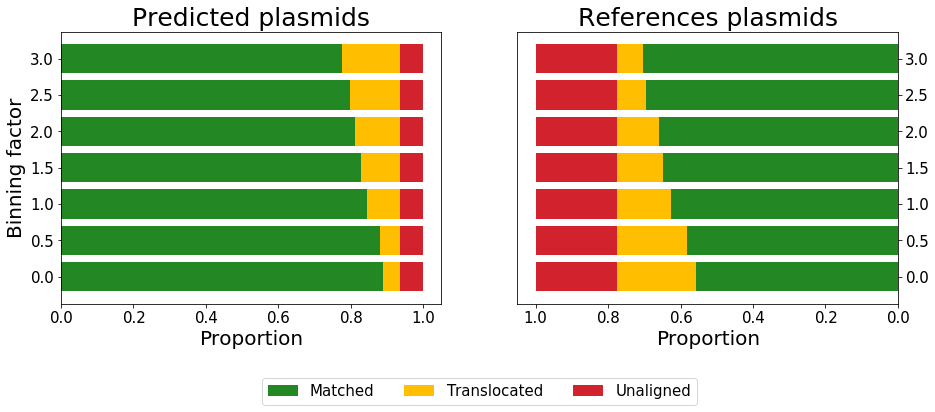

In [11]:
plot_proportions(totals_hyasp_mob_pred, totals_hyasp_mob_ref, 'Binning factor', list(totals_hyasp_mob_pred['bf']), 'proportions_bfs_mob')

*Translocated and unaligned proportions of individual predicted and reference plasmids for different binning factors*

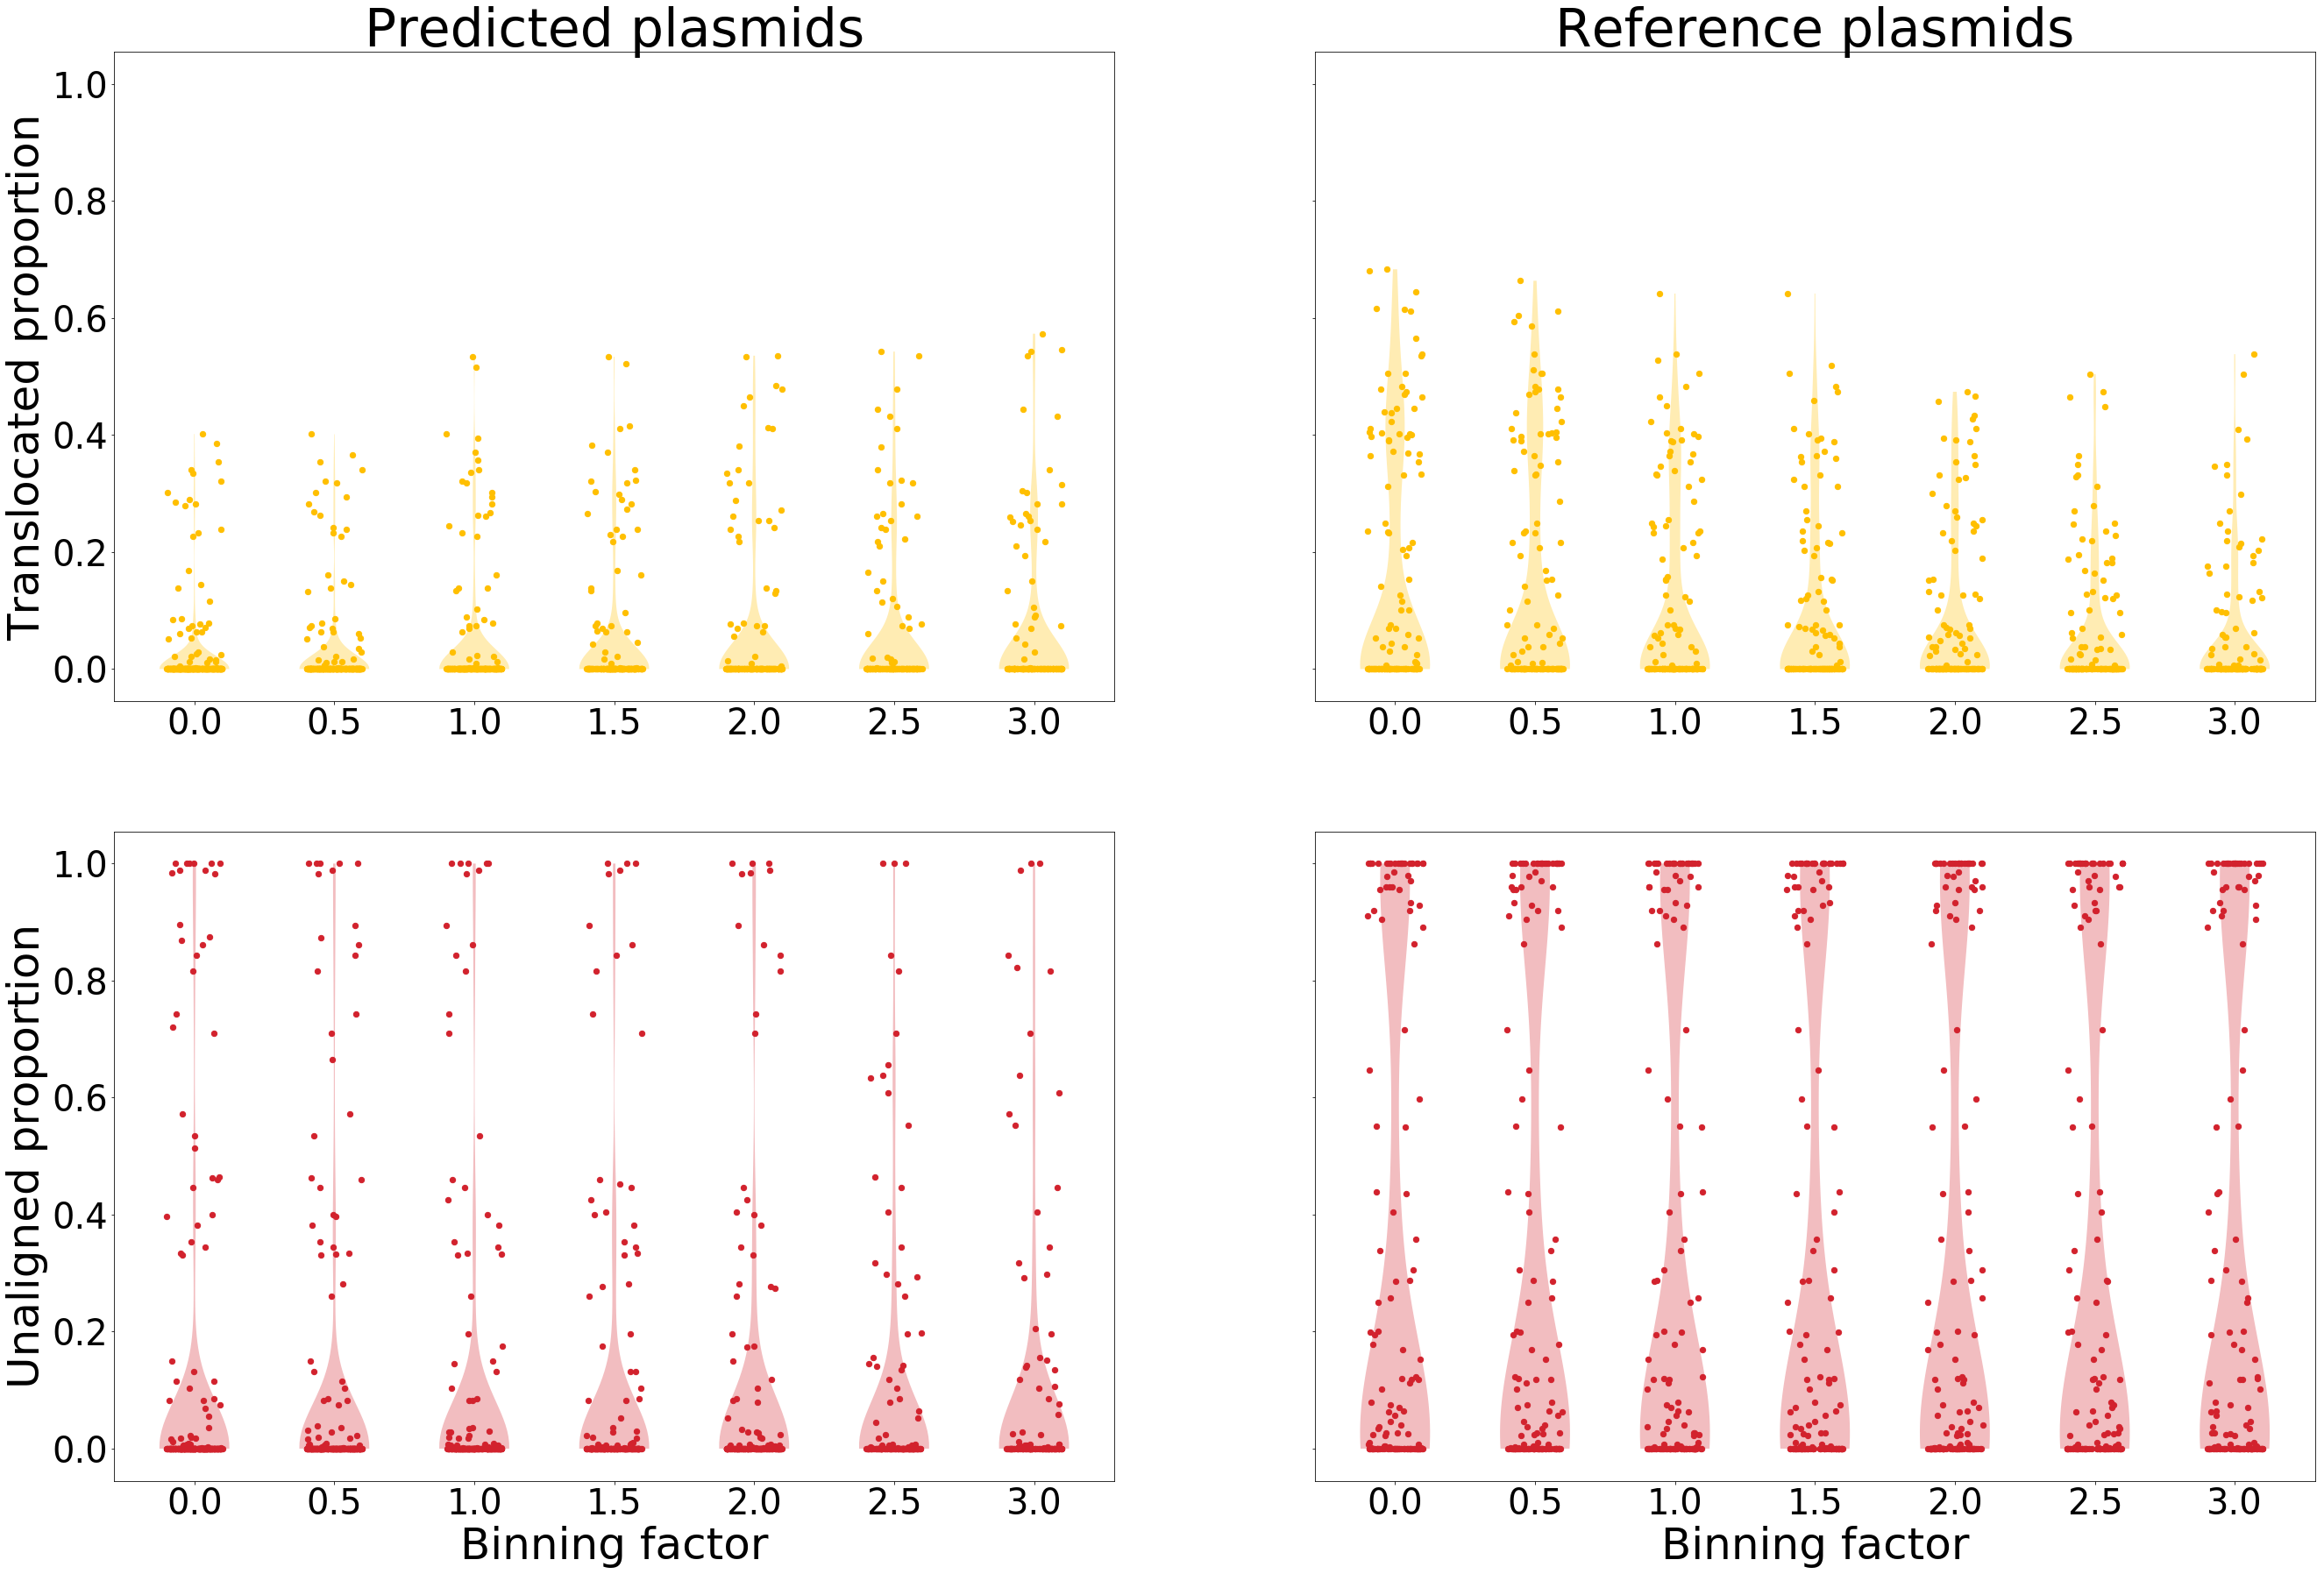

In [12]:
plot_distributions_bfs(hyasp_results_mob_pred, hyasp_results_mob_ref, 'distributions_bfs_mob')

*Length versus translocated / unaligned proportions of individual predicted and reference plasmids for different binning factors*

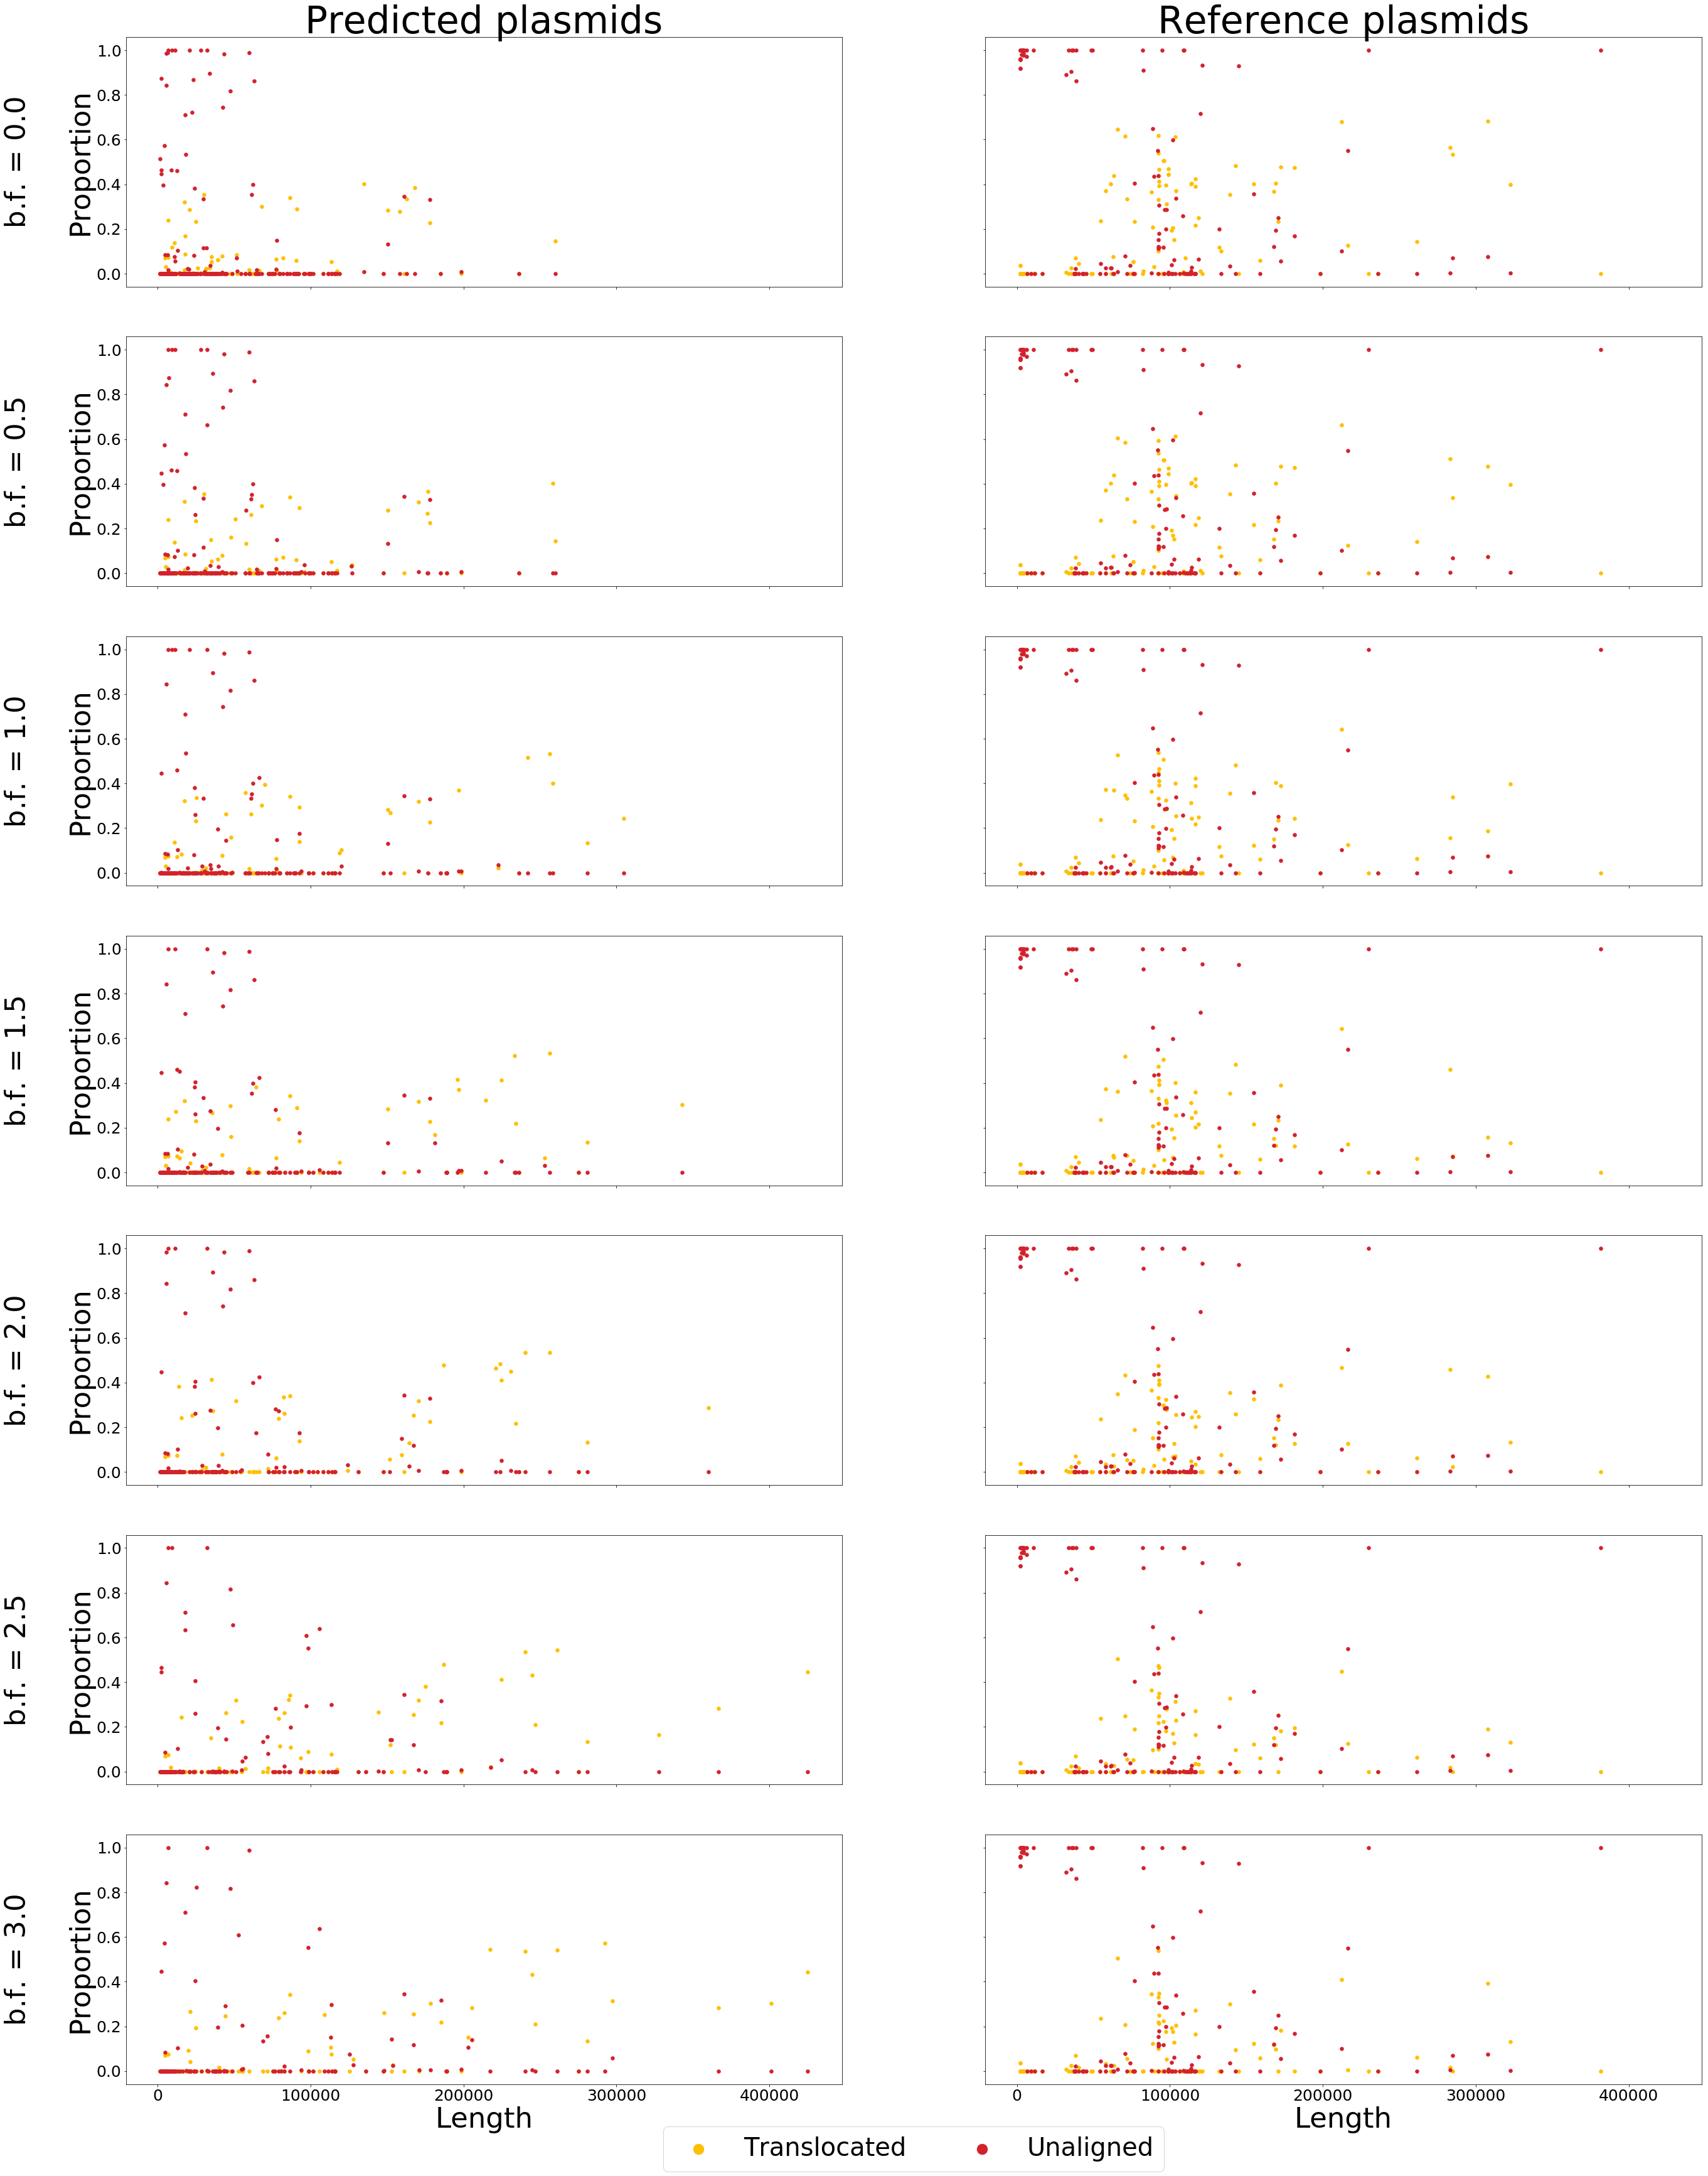

In [13]:
plot_length_vs_props_bfs(hyasp_results_mob_pred, hyasp_results_mob_ref, 'length_vs_props_bfs_mob')

### Scores

'matched' corresponds to best-scores, 'matched' plus 'translocated' corresponds to union-scores.

In [14]:
contents = []
for bf in [0.0] + binning_factors:
    pred_row = totals_hyasp_mob_pred.loc[totals_hyasp_mob_pred['bf'] == bf]
    pred_matched = pred_row['matched'].item()
    pred_translocated = pred_row['translocated'].item()
    
    ref_row = totals_hyasp_mob_ref.loc[totals_hyasp_mob_ref['bf'] == bf]
    ref_matched = ref_row['matched'].item()
    ref_translocated = ref_row['translocated'].item()
    
    best_precision = pred_matched
    best_recall = ref_matched
    best_f1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    
    union_precision = pred_matched + pred_translocated
    union_recall = ref_matched + ref_translocated
    union_f1 = 2 * union_precision * union_recall / (union_precision + union_recall) if (union_precision + union_recall) > 0 else 0
    
    contents.append([bf, 'union', union_precision, union_recall, union_f1])
    contents.append([bf, 'best', best_precision, best_recall, best_f1])
    
total_scores_hyasp = pd.DataFrame(contents, columns = ['bf', 'evaluation', 'precision', 'recall', 'f1'])
total_scores_hyasp

,bf,evaluation,precision,recall,f1
0,0.0,union,0.934516,0.775171,0.847418
1,0.0,best,0.887890,0.556486,0.684168
2,0.5,union,0.934516,0.775171,0.847418
3,0.5,best,0.879210,0.581641,0.700118
4,1.0,union,0.934516,0.775171,0.847418
5,1.0,best,0.843853,0.627313,0.719647
6,1.5,union,0.934516,0.775171,0.847418
7,1.5,best,0.828352,0.647787,0.727026
8,2.0,union,0.934516,0.775171,0.847418
9,2.0,best,0.811328,0.660774,0.728352


## NCBI-database

In [15]:
run = 'ncbi_filtered'
test_ids = [1,5,15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,55,56,62,63,64,65,66,76,85,86,87,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]
binning_factors = [0.5, 1, 1.5, 2, 2.5, 3]

*Compute from scratch* (or see below to load from CSV file).

In [ ]:
hyasp_results_pred = []
hyasp_results_ref = []

# unbinned
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/greedy/plasmids/greedy/putative_plasmids.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_hyasp_plasmids(sid, predictions_file, references_file, map_file)
    hyasp_results_pred += pred_results
    hyasp_results_ref += ref_results

# results of different runs with binning
for bf in binning_factors:
    for sid in test_ids:
        out_dir = 'hyasp_binning_option/%s/sample_%i/bins_%f' % (run, sid, bf)
        bin_list_file = '%s/plasmid_bins_putative.csv' % out_dir

        p = subprocess.Popen('ls %s/bin_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
        output, _ = p.communicate()
        p.wait()
        predictions_files = output.rstrip().decode().split('\n')
        if predictions_files == ['']:
            predictions_files = []

        references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
        map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)

        pred_results, ref_results = analyse_hyasp_bins(sid, bf, bin_list_file, predictions_files, references_file, map_file)
        hyasp_results_pred += pred_results
        hyasp_results_ref += ref_results
    
hyasp_results_ncbi_pred = pd.DataFrame(hyasp_results_pred, columns = ['sample_id', 'tool', 'prediction', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
hyasp_results_ncbi_pred.to_csv('hyasp_results_ncbi_pred.csv', index = False)

hyasp_results_ncbi_ref = pd.DataFrame(hyasp_results_ref, columns = ['sample_id', 'tool', 'reference', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
hyasp_results_ncbi_ref.to_csv('hyasp_results_ncbi_ref.csv', index = False)

*Load results from CSV files*

In [16]:
hyasp_results_ncbi_pred = pd.read_csv('hyasp_results_ncbi_pred.csv')
hyasp_results_ncbi_ref = pd.read_csv('hyasp_results_ncbi_ref.csv')

*Proportion of predicted plasmids with translocations*

In [17]:
contents = []
for bf, grp in hyasp_results_ncbi_pred.groupby(['bf']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([bf, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['bf', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,bf,prop_translocated,num_translocated,num_matched,num_plasmids
0,0.0,0.147959,58,392,490
1,0.5,0.201923,63,312,395
2,1.0,0.226337,55,243,315
3,1.5,0.248756,50,201,263
4,2.0,0.270115,47,174,229
5,2.5,0.287582,44,153,202
6,3.0,0.304965,43,141,185


*Proportion of reference plasmids with translocations*

In [18]:
contents = []
for bf, grp in hyasp_results_ncbi_ref.groupby(['bf']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([bf, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['bf', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,bf,prop_translocated,num_translocated,num_matched,num_plasmids
0,0.0,0.539007,76,141,147
1,0.5,0.517730,73,141,147
2,1.0,0.489362,69,141,147
3,1.5,0.468085,66,141,147
4,2.0,0.453901,64,141,147
5,2.5,0.411348,58,141,147
6,3.0,0.368794,52,141,147


### Translocations w.r.t. predictions (precision)

Proportion of (nucleotides of) predicted plasmids corresponding to best respective reference ('matched'), other references ('translocated') and none of the references ('unaligned').

In [19]:
contents = []
for bf, grp in hyasp_results_ncbi_pred.groupby(['bf']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([bf, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_hyasp_ncbi_pred = pd.DataFrame(contents, columns = ['bf', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_hyasp_ncbi_pred

,bf,total_length,matched,translocated,unaligned
0,0.0,13145252,0.825117,0.046330,0.128553
1,0.5,13145252,0.798782,0.072665,0.128553
2,1.0,13145252,0.766870,0.104576,0.128553
3,1.5,13145252,0.744826,0.126621,0.128553
4,2.0,13145252,0.720998,0.150448,0.128553
5,2.5,13145252,0.712097,0.159350,0.128553
6,3.0,13145252,0.691098,0.180348,0.128553


### Translocations w.r.t. references (recall)

Proportion of (nucleotides of) reference plasmids corresponding to respective best predicted plasmid ('matched'), other predicted plasmids ('translocated') and none of the predicted plasmids ('unaligned').

In [20]:
contents = []
for bf, grp in hyasp_results_ncbi_ref.groupby(['bf']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([bf, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_hyasp_ncbi_ref = pd.DataFrame(contents, columns = ['bf', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_hyasp_ncbi_ref

,bf,total_length,matched,translocated,unaligned
0,0.0,12435483,0.621696,0.277128,0.101176
1,0.5,12435483,0.663699,0.235125,0.101176
2,1.0,12435483,0.705347,0.193477,0.101176
3,1.5,12435483,0.767100,0.131724,0.101176
4,2.0,12435483,0.806556,0.092268,0.101176
5,2.5,12435483,0.816356,0.082468,0.101176
6,3.0,12435483,0.827507,0.071317,0.101176


*Visualisation of translocations w.r.t. predictions and references for different binning factors*

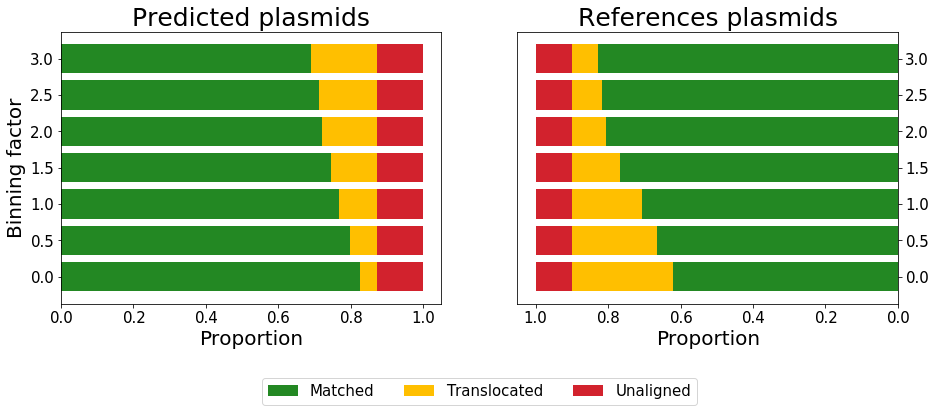

In [21]:
plot_proportions(totals_hyasp_ncbi_pred, totals_hyasp_ncbi_ref, 'Binning factor', list(totals_hyasp_ncbi_pred['bf']), 'proportions_bfs_ncbi')

*Visualisation of translocated and unaligned proportions of individual predicted and reference plasmids for different binning factors*

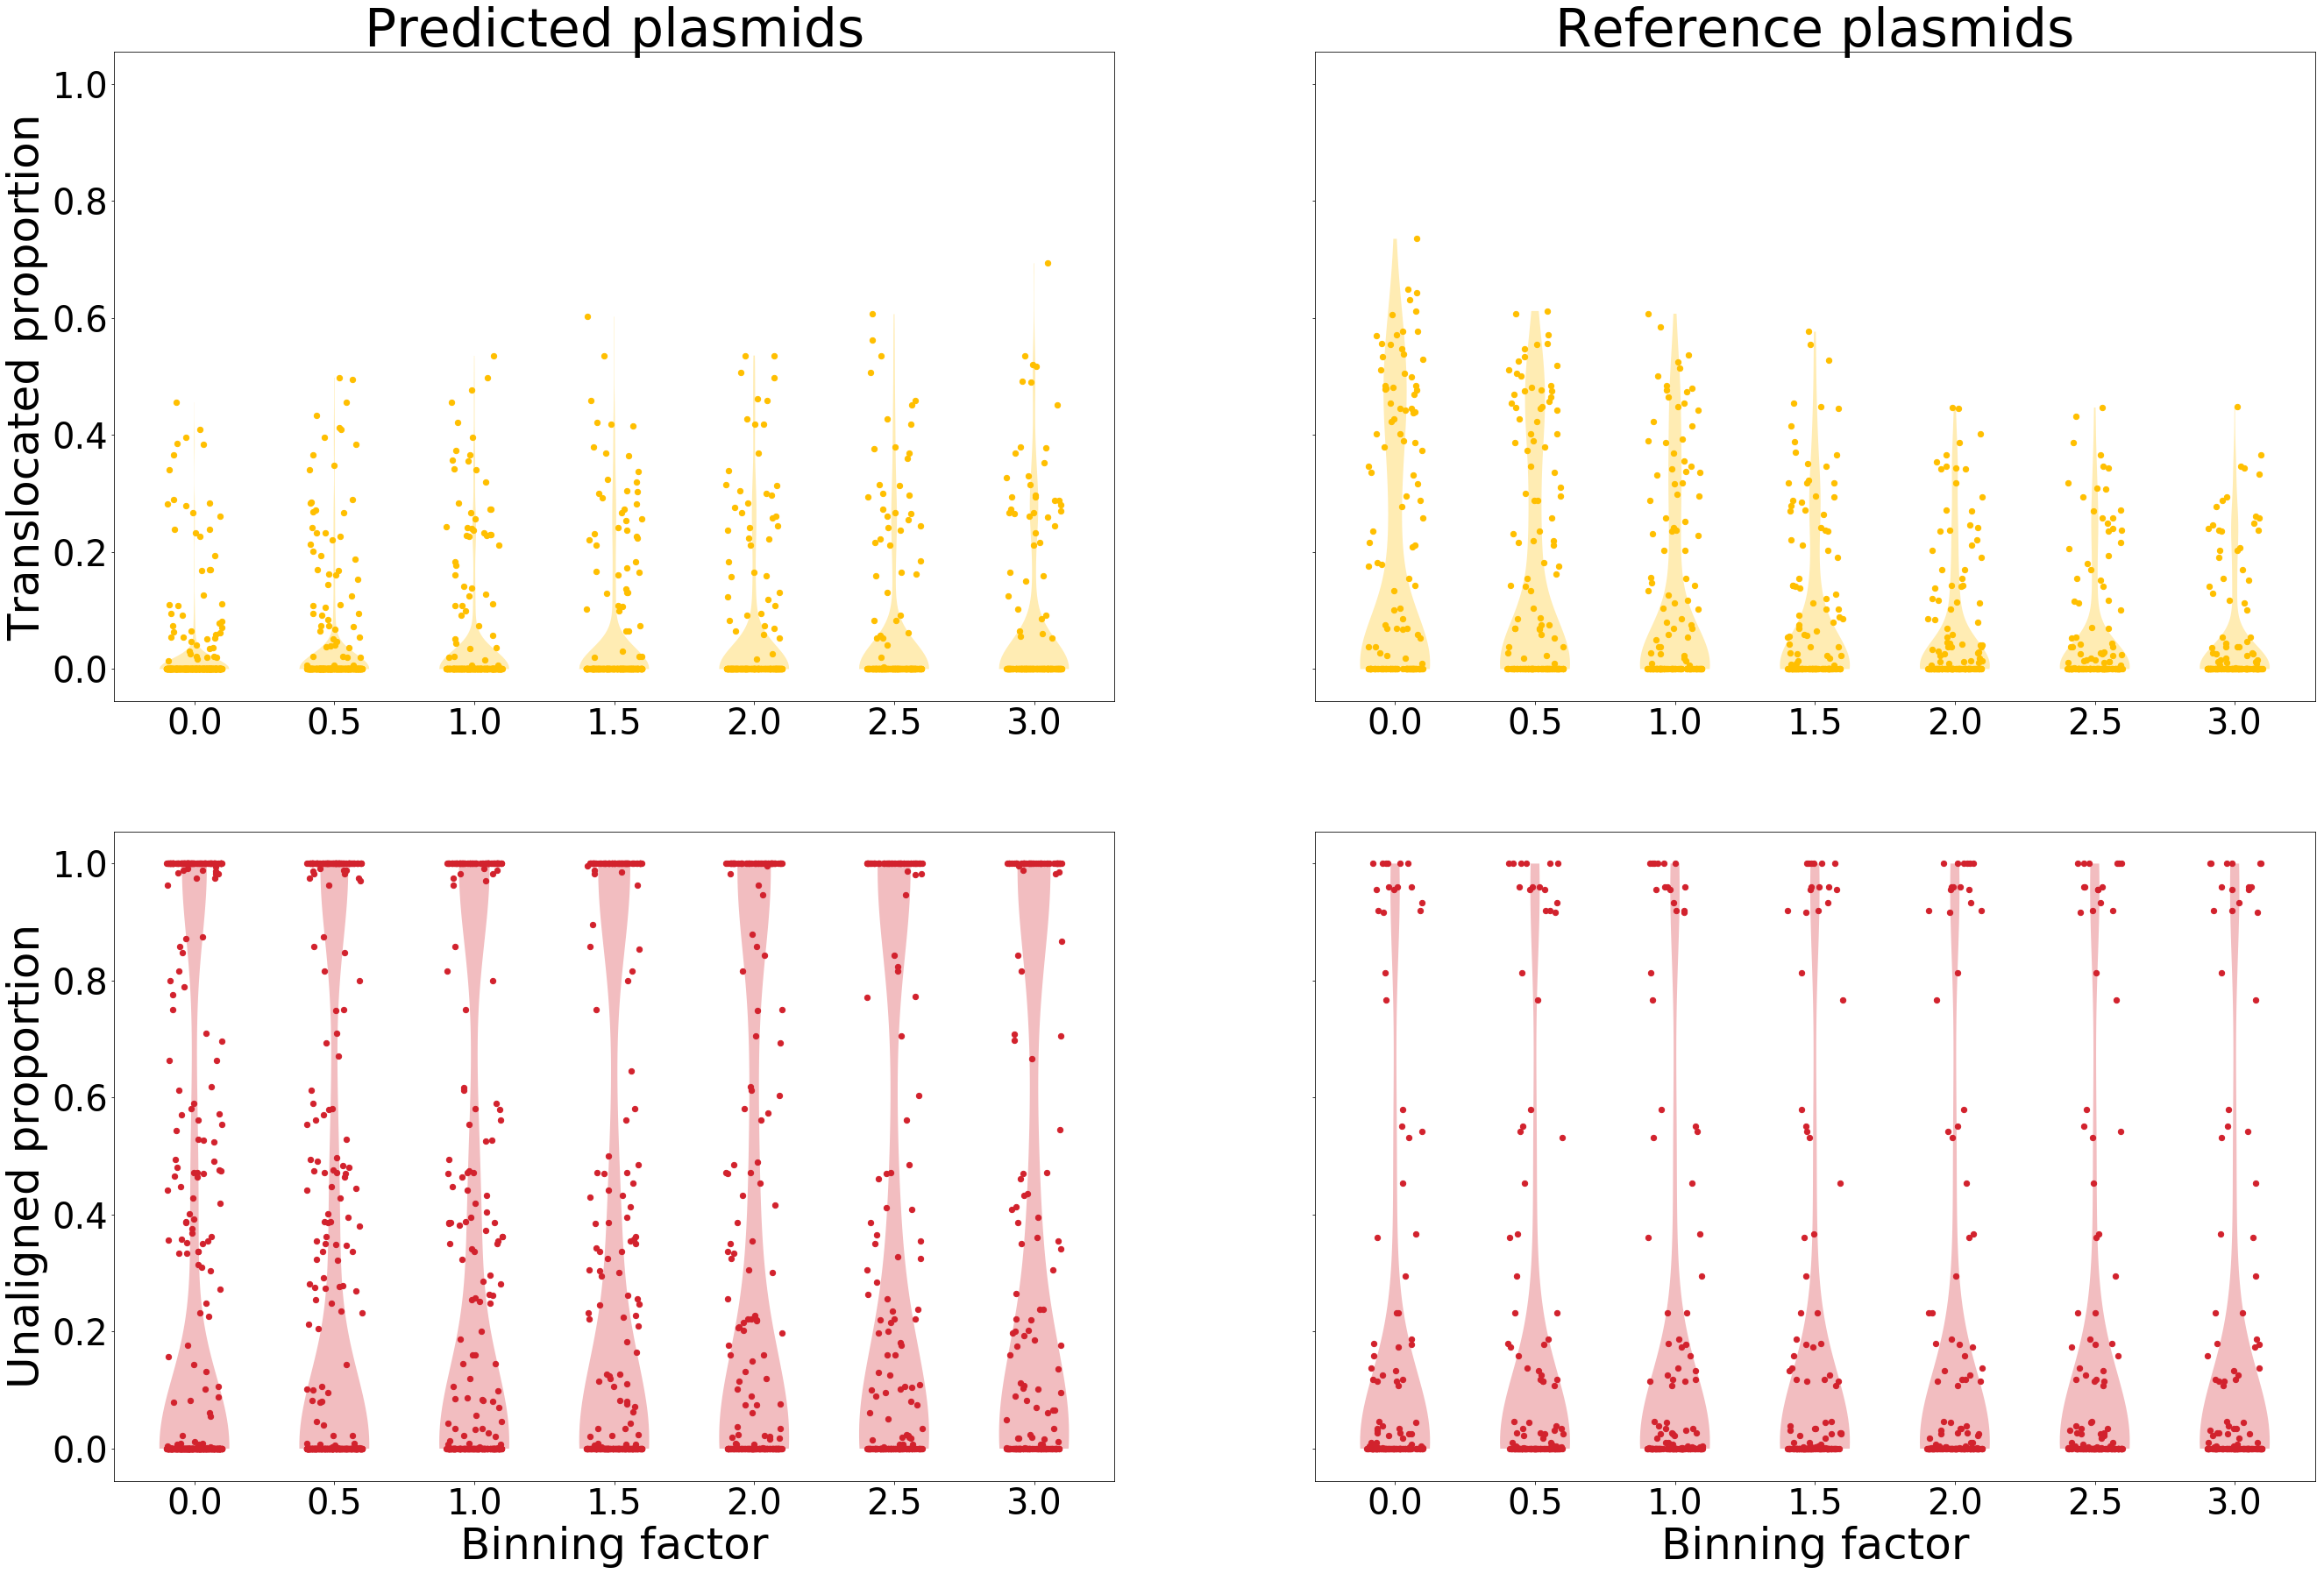

In [22]:
plot_distributions_bfs(hyasp_results_ncbi_pred, hyasp_results_ncbi_ref, 'distributions_bfs_ncbi')

*Length versus translocated / unaligned proportions of individual predicted and reference plasmids for different binning factors*

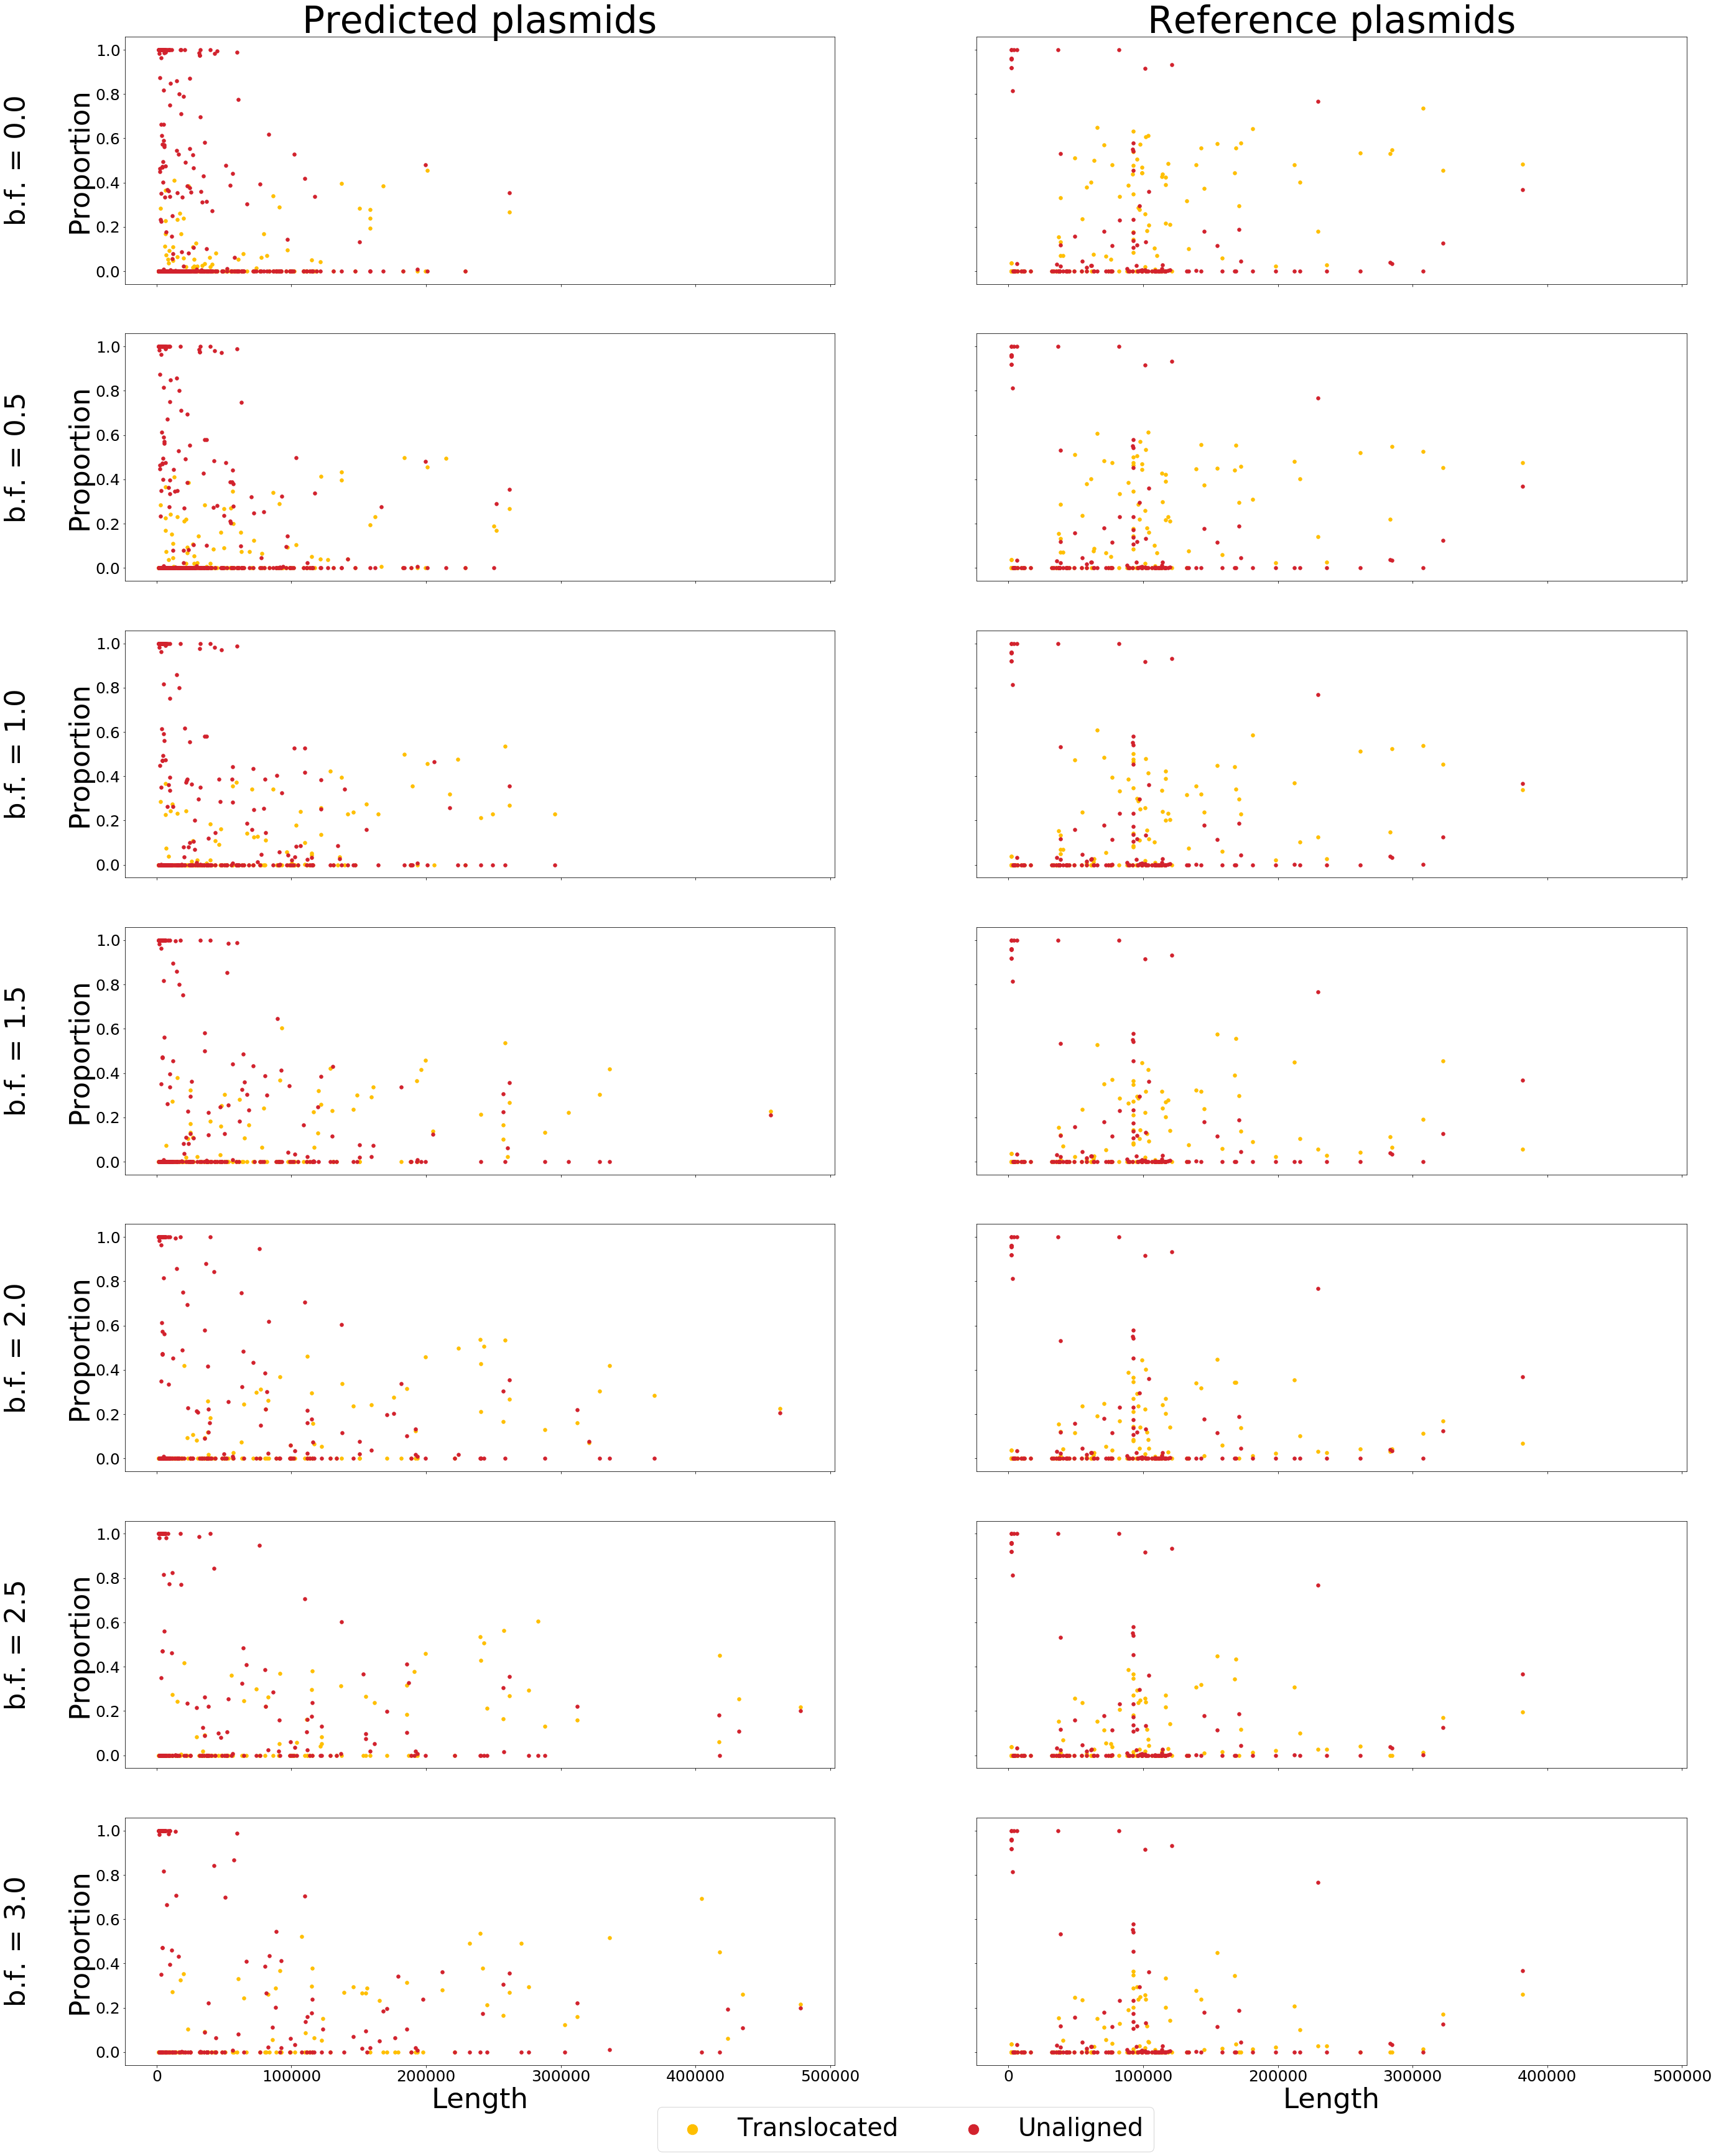

In [23]:
plot_length_vs_props_bfs(hyasp_results_ncbi_pred, hyasp_results_ncbi_ref, 'length_vs_props_bfs_ncbi')

### Scores

'matched' corresponds to best-scores, 'matched' plus 'translocated' corresponds to union-scores.

In [24]:
contents = []
for bf in [0.0] + binning_factors:
    pred_row = totals_hyasp_ncbi_pred.loc[totals_hyasp_ncbi_pred['bf'] == bf]
    pred_matched = pred_row['matched'].item()
    pred_translocated = pred_row['translocated'].item()
    
    ref_row = totals_hyasp_ncbi_ref.loc[totals_hyasp_ncbi_ref['bf'] == bf]
    ref_matched = ref_row['matched'].item()
    ref_translocated = ref_row['translocated'].item()
    
    best_precision = pred_matched
    best_recall = ref_matched
    best_f1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    
    union_precision = pred_matched + pred_translocated
    union_recall = ref_matched + ref_translocated
    union_f1 = 2 * union_precision * union_recall / (union_precision + union_recall) if (union_precision + union_recall) > 0 else 0
    
    contents.append([bf, 'union', union_precision, union_recall, union_f1])
    contents.append([bf, 'best', best_precision, best_recall, best_f1])
    
total_scores_hyasp = pd.DataFrame(contents, columns = ['bf', 'evaluation', 'precision', 'recall', 'f1'])
total_scores_hyasp

,bf,evaluation,precision,recall,f1
0,0.0,union,0.871447,0.898824,0.884924
1,0.0,best,0.825117,0.621696,0.709106
2,0.5,union,0.871447,0.898824,0.884924
3,0.5,best,0.798782,0.663699,0.725002
4,1.0,union,0.871447,0.898824,0.884924
5,1.0,best,0.766870,0.705347,0.734823
6,1.5,union,0.871447,0.898824,0.884924
7,1.5,best,0.744826,0.767100,0.755799
8,2.0,union,0.871447,0.898824,0.884924
9,2.0,best,0.720998,0.806556,0.761381


# HyAsP vs other tools

## MOB-database

In [25]:
run = 'mob_filtered'
test_ids = [1,5,15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,55,56,62,63,64,65,66,76,85,86,87,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]

*Compute from scratch* (or see below to load from CSV file).

In [ ]:
all_results_pred = []
all_results_ref = []

# HyAsP (plasmids)
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/greedy/plasmids/greedy/putative_plasmids.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_hyasp_plasmids(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results

# HyAsP (bins)
bf = 2.5
for sid in test_ids:
    out_dir = 'hyasp_binning_option/%s/sample_%i/bins_%f' % (run, sid, bf)
    bin_list_file = '%s/plasmid_bins_putative.csv' % out_dir

    p = subprocess.Popen('ls %s/bin_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    predictions_files = output.rstrip().decode().split('\n')
    if predictions_files == ['']:
        predictions_files = []

    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)

    pred_results, ref_results = analyse_hyasp_bins(sid, bf, bin_list_file, predictions_files, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results
    
# MOB-recon
for sid in test_ids:
    out_dir = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i' % (run, sid)

    p = subprocess.Popen('ls %s/mob_recon/plasmid_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    predictions_files = output.rstrip().decode().split('\n')
    if predictions_files == ['']:
        predictions_files = []

    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)

    p = subprocess.Popen('ls %s/eval/mob_recon/mob_recon_*_map.csv' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    map_files = output.rstrip().decode().split('\n')
    if map_files == ['']:
        map_files = []
        
    pred_results, ref_results = analyse_mob_recon(sid, predictions_files, references_file, map_files)
    all_results_pred += pred_results
    all_results_ref += ref_results

# plasmidSPAdes
for sid in test_ids:
    out_dir = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i' % (run, sid)

    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/plasmidspades/scaffolds.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmidspades/plasmidspades_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_plasmidspades(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results
    
# Recycler
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/plasmids/%i_assembly_graph.cycs.fasta' % sid
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/eval/%i_recycler_map.csv' % sid
    
    pred_results, ref_results = analyse_recycler(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results
    
all_results_mob_pred = pd.DataFrame(all_results_pred, columns = ['sample_id', 'tool', 'prediction', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
all_results_mob_pred.to_csv('all_results_mob_pred.csv', index = False)

all_results_mob_ref = pd.DataFrame(all_results_ref, columns = ['sample_id', 'tool', 'reference', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
all_results_mob_ref.to_csv('all_results_mob_ref.csv', index = False)

*Load results from CSV files*

In [26]:
all_results_mob_pred = pd.read_csv('all_results_mob_pred.csv')
all_results_mob_ref = pd.read_csv('all_results_mob_ref.csv')

*Proportion of predicted plasmids with translocations*

In [27]:
contents = []
for t, grp in all_results_mob_pred.groupby(['tool']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([t, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['tool', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,tool,prop_translocated,num_translocated,num_matched,num_plasmids
0,HyAsP_bins,0.267974,41,153,156
1,HyAsP_plasmids,0.163763,47,287,293
2,MOB-recon,0.011538,3,260,287
3,Recycler,0.000000,0,60,108
4,plasmidSPAdes,0.230088,26,113,166


*Proportion of reference plasmids with translocations*

In [28]:
contents = []
for t, grp in all_results_mob_ref.groupby(['tool']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([t, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['tool', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,tool,prop_translocated,num_translocated,num_matched,num_plasmids
0,HyAsP_bins,0.416000,52,125,147
1,HyAsP_plasmids,0.560000,70,125,147
2,MOB-recon,0.452055,66,146,147
3,Recycler,0.031250,2,64,147
4,plasmidSPAdes,0.050360,7,139,147


### Translocations w.r.t. predictions (precision)

Proportion of (nucleotides of) predicted plasmids corresponding to best respective reference ('matched'), other references ('translocated') and none of the references ('unaligned').

In [29]:
contents = []
for tool, grp in all_results_mob_pred.groupby(['tool']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([tool, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_all_mob_pred = pd.DataFrame(contents, columns = ['tool', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_all_mob_pred

,tool,total_length,matched,translocated,unaligned
0,HyAsP_bins,10661462,0.798238,0.136278,0.065484
1,HyAsP_plasmids,10661462,0.887890,0.046626,0.065484
2,MOB-recon,9307302,0.756172,0.004071,0.239758
3,Recycler,3654289,0.349300,0.000000,0.650700
4,plasmidSPAdes,13647445,0.560784,0.098428,0.340788


HyAsP_bins with binning factor 2.5

### Translocations w.r.t. references (recall)

Proportion of (nucleotides of) reference plasmids corresponding to respective best predicted plasmid ('matched'), other predicted plasmids ('translocated') and none of the predicted plasmids ('unaligned').

In [30]:
contents = []
for tool, grp in all_results_mob_ref.groupby(['tool']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([tool, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_all_mob_ref = pd.DataFrame(contents, columns = ['tool', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_all_mob_ref

,tool,total_length,matched,translocated,unaligned
0,HyAsP_bins,12435483,0.695159,0.080012,0.224829
1,HyAsP_plasmids,12435483,0.556486,0.218686,0.224829
2,MOB-recon,12435483,0.474530,0.109381,0.416089
3,Recycler,12435483,0.103061,0.000718,0.896221
4,plasmidSPAdes,12435483,0.736594,0.005391,0.258015


HyAsP_bins with binning factor 2.5

*Visualisation of translocations w.r.t. predictions and references for different tools*

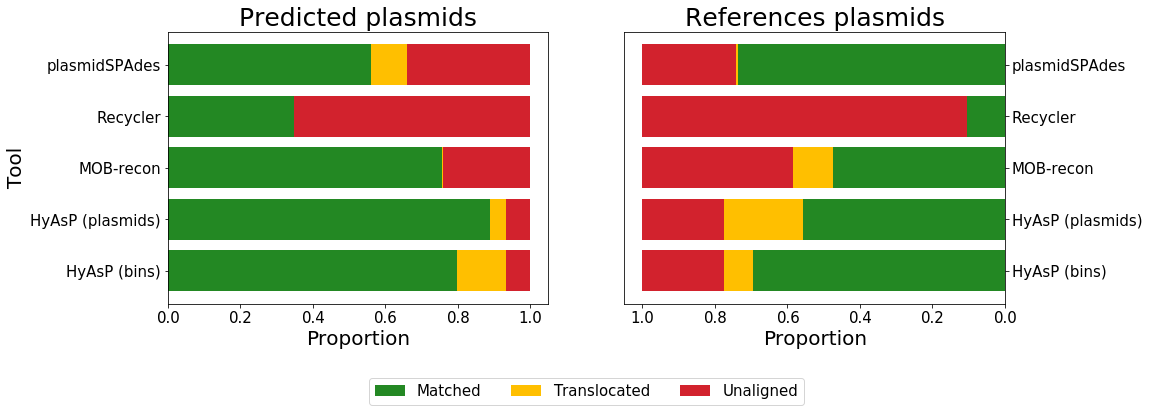

In [31]:
tick_labels = ['HyAsP (bins)', 'HyAsP (plasmids)', 'MOB-recon', 'Recycler', 'plasmidSPAdes']
plot_proportions(totals_all_mob_pred, totals_all_mob_ref, 'Tool', tick_labels, 'proportions_tools_mob')

*Visualisation of translocated and unaligned proportions of individual predicted and reference plasmids for different tools*

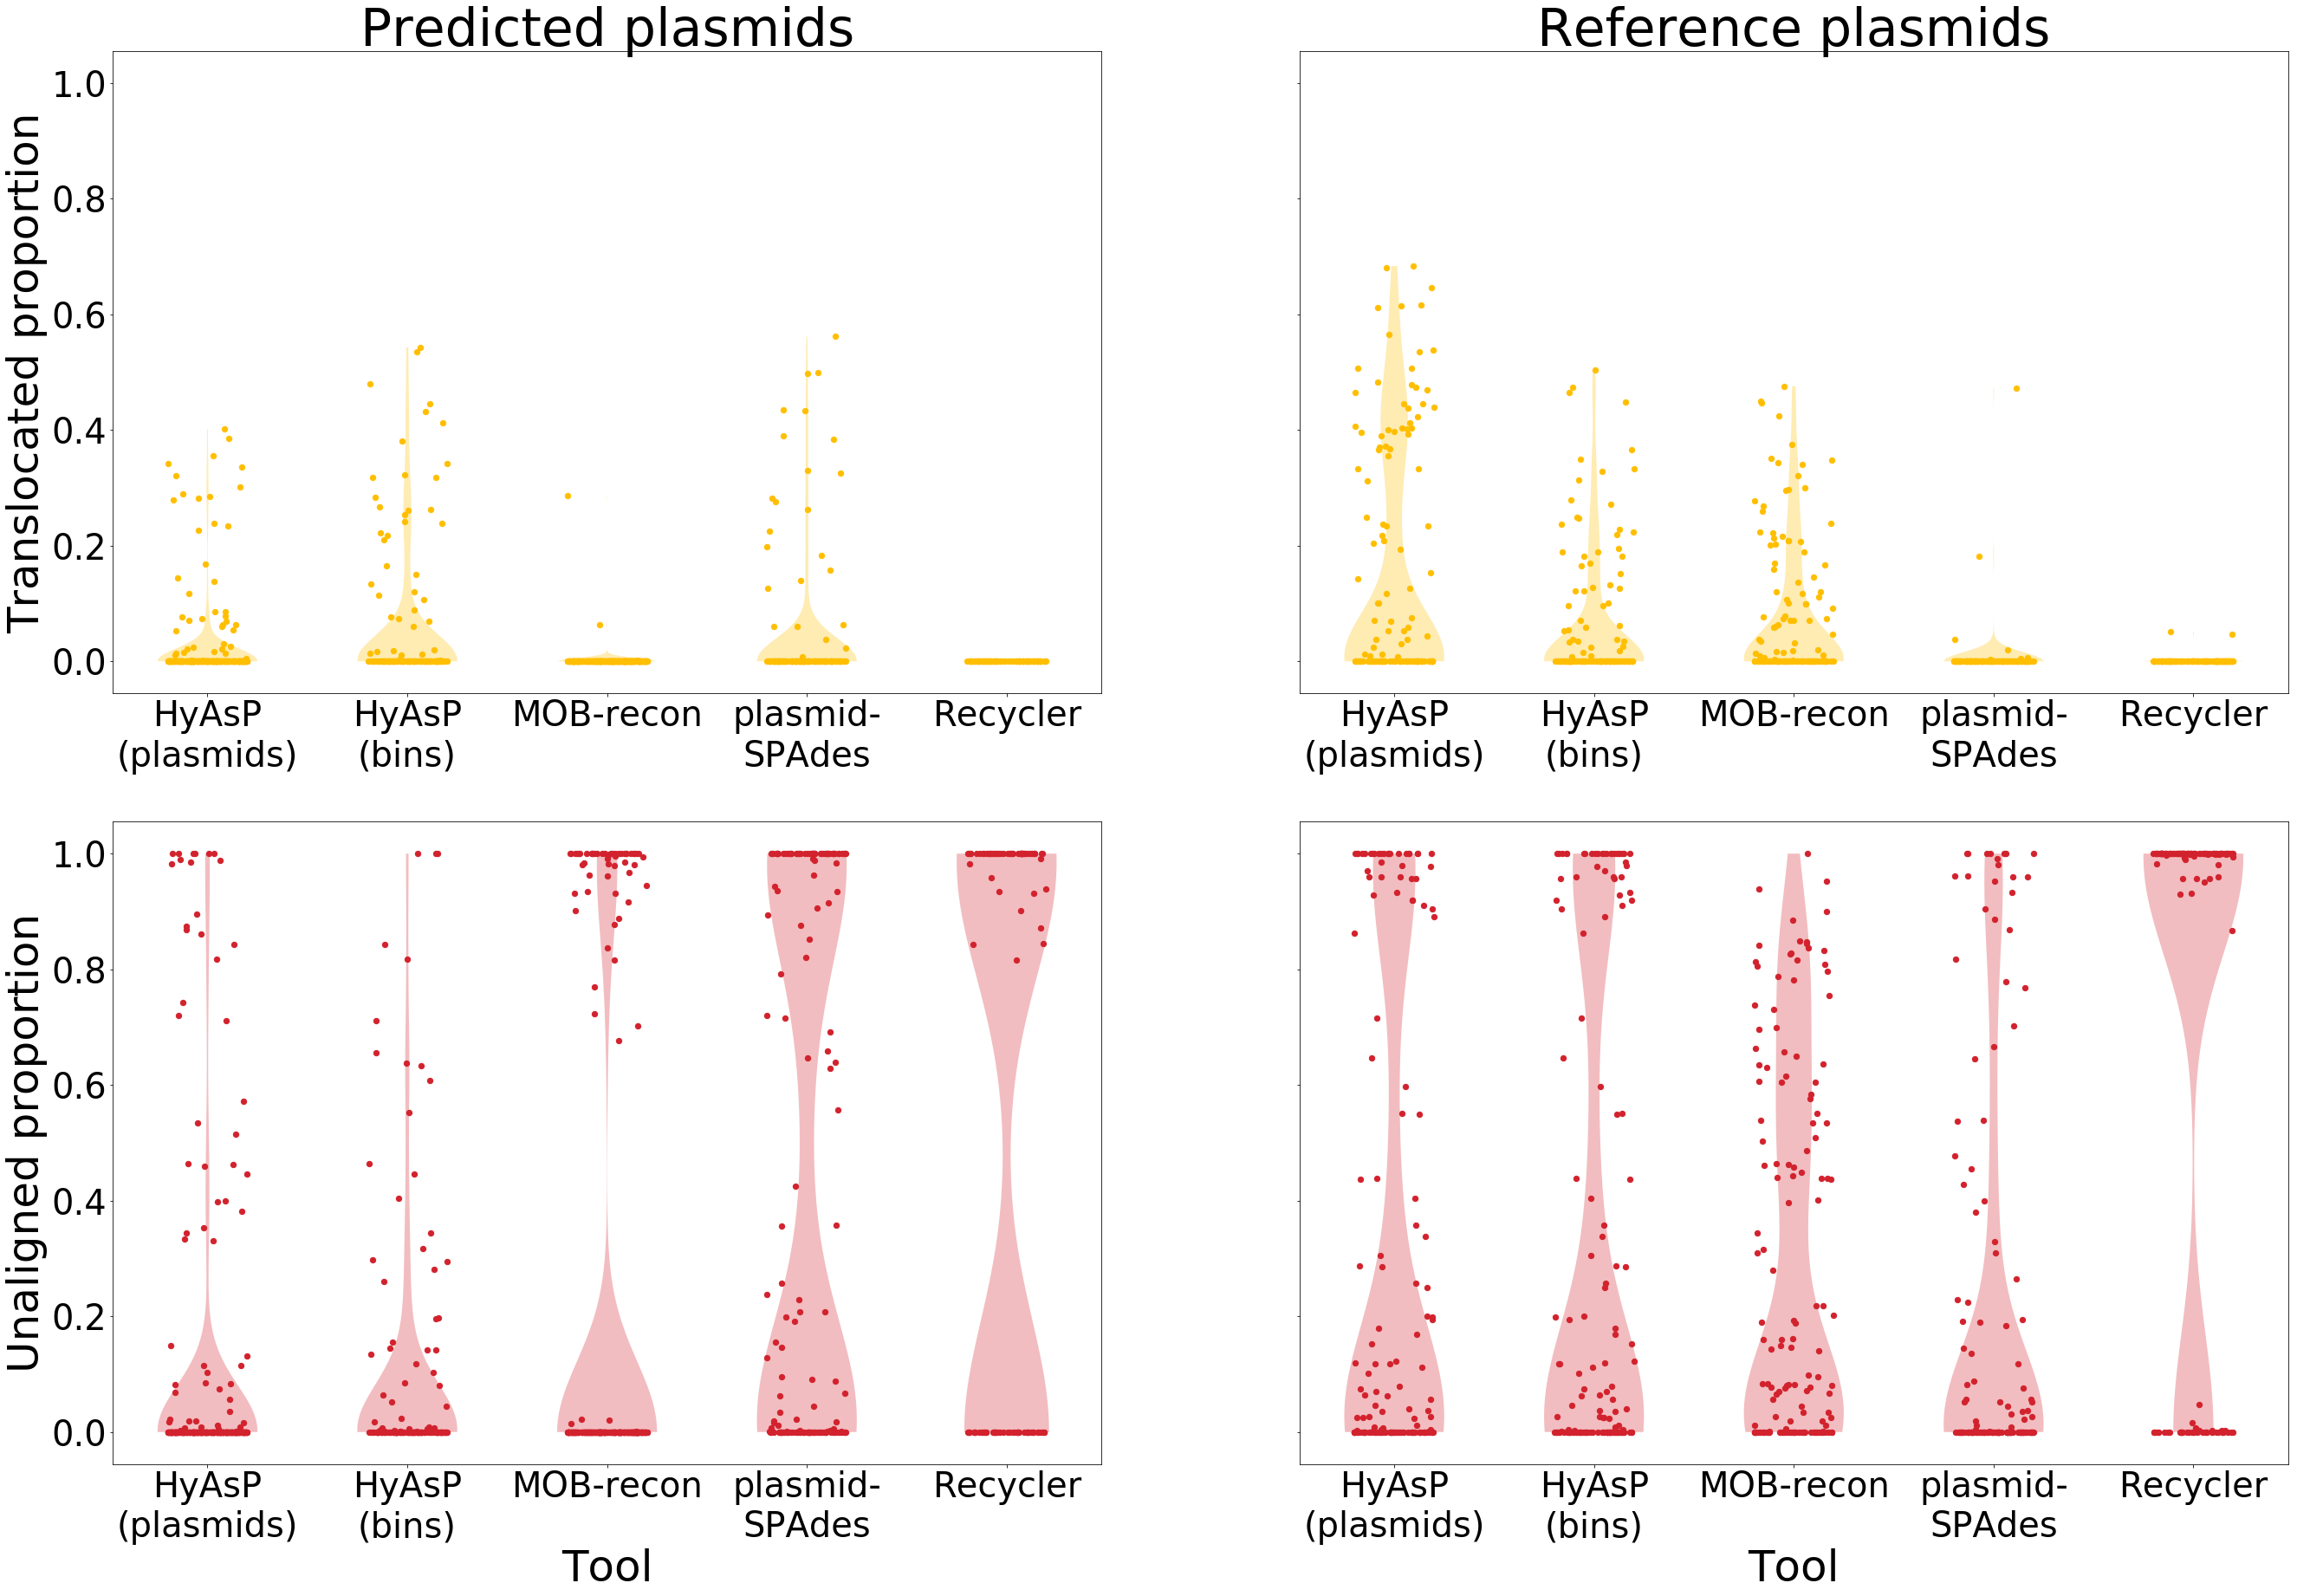

In [32]:
plot_distributions_tools(all_results_mob_pred, all_results_mob_ref, 'distributions_tools_mob')

*Length versus translocated / unaligned proportions of individual predicted and reference plasmids for different tools*

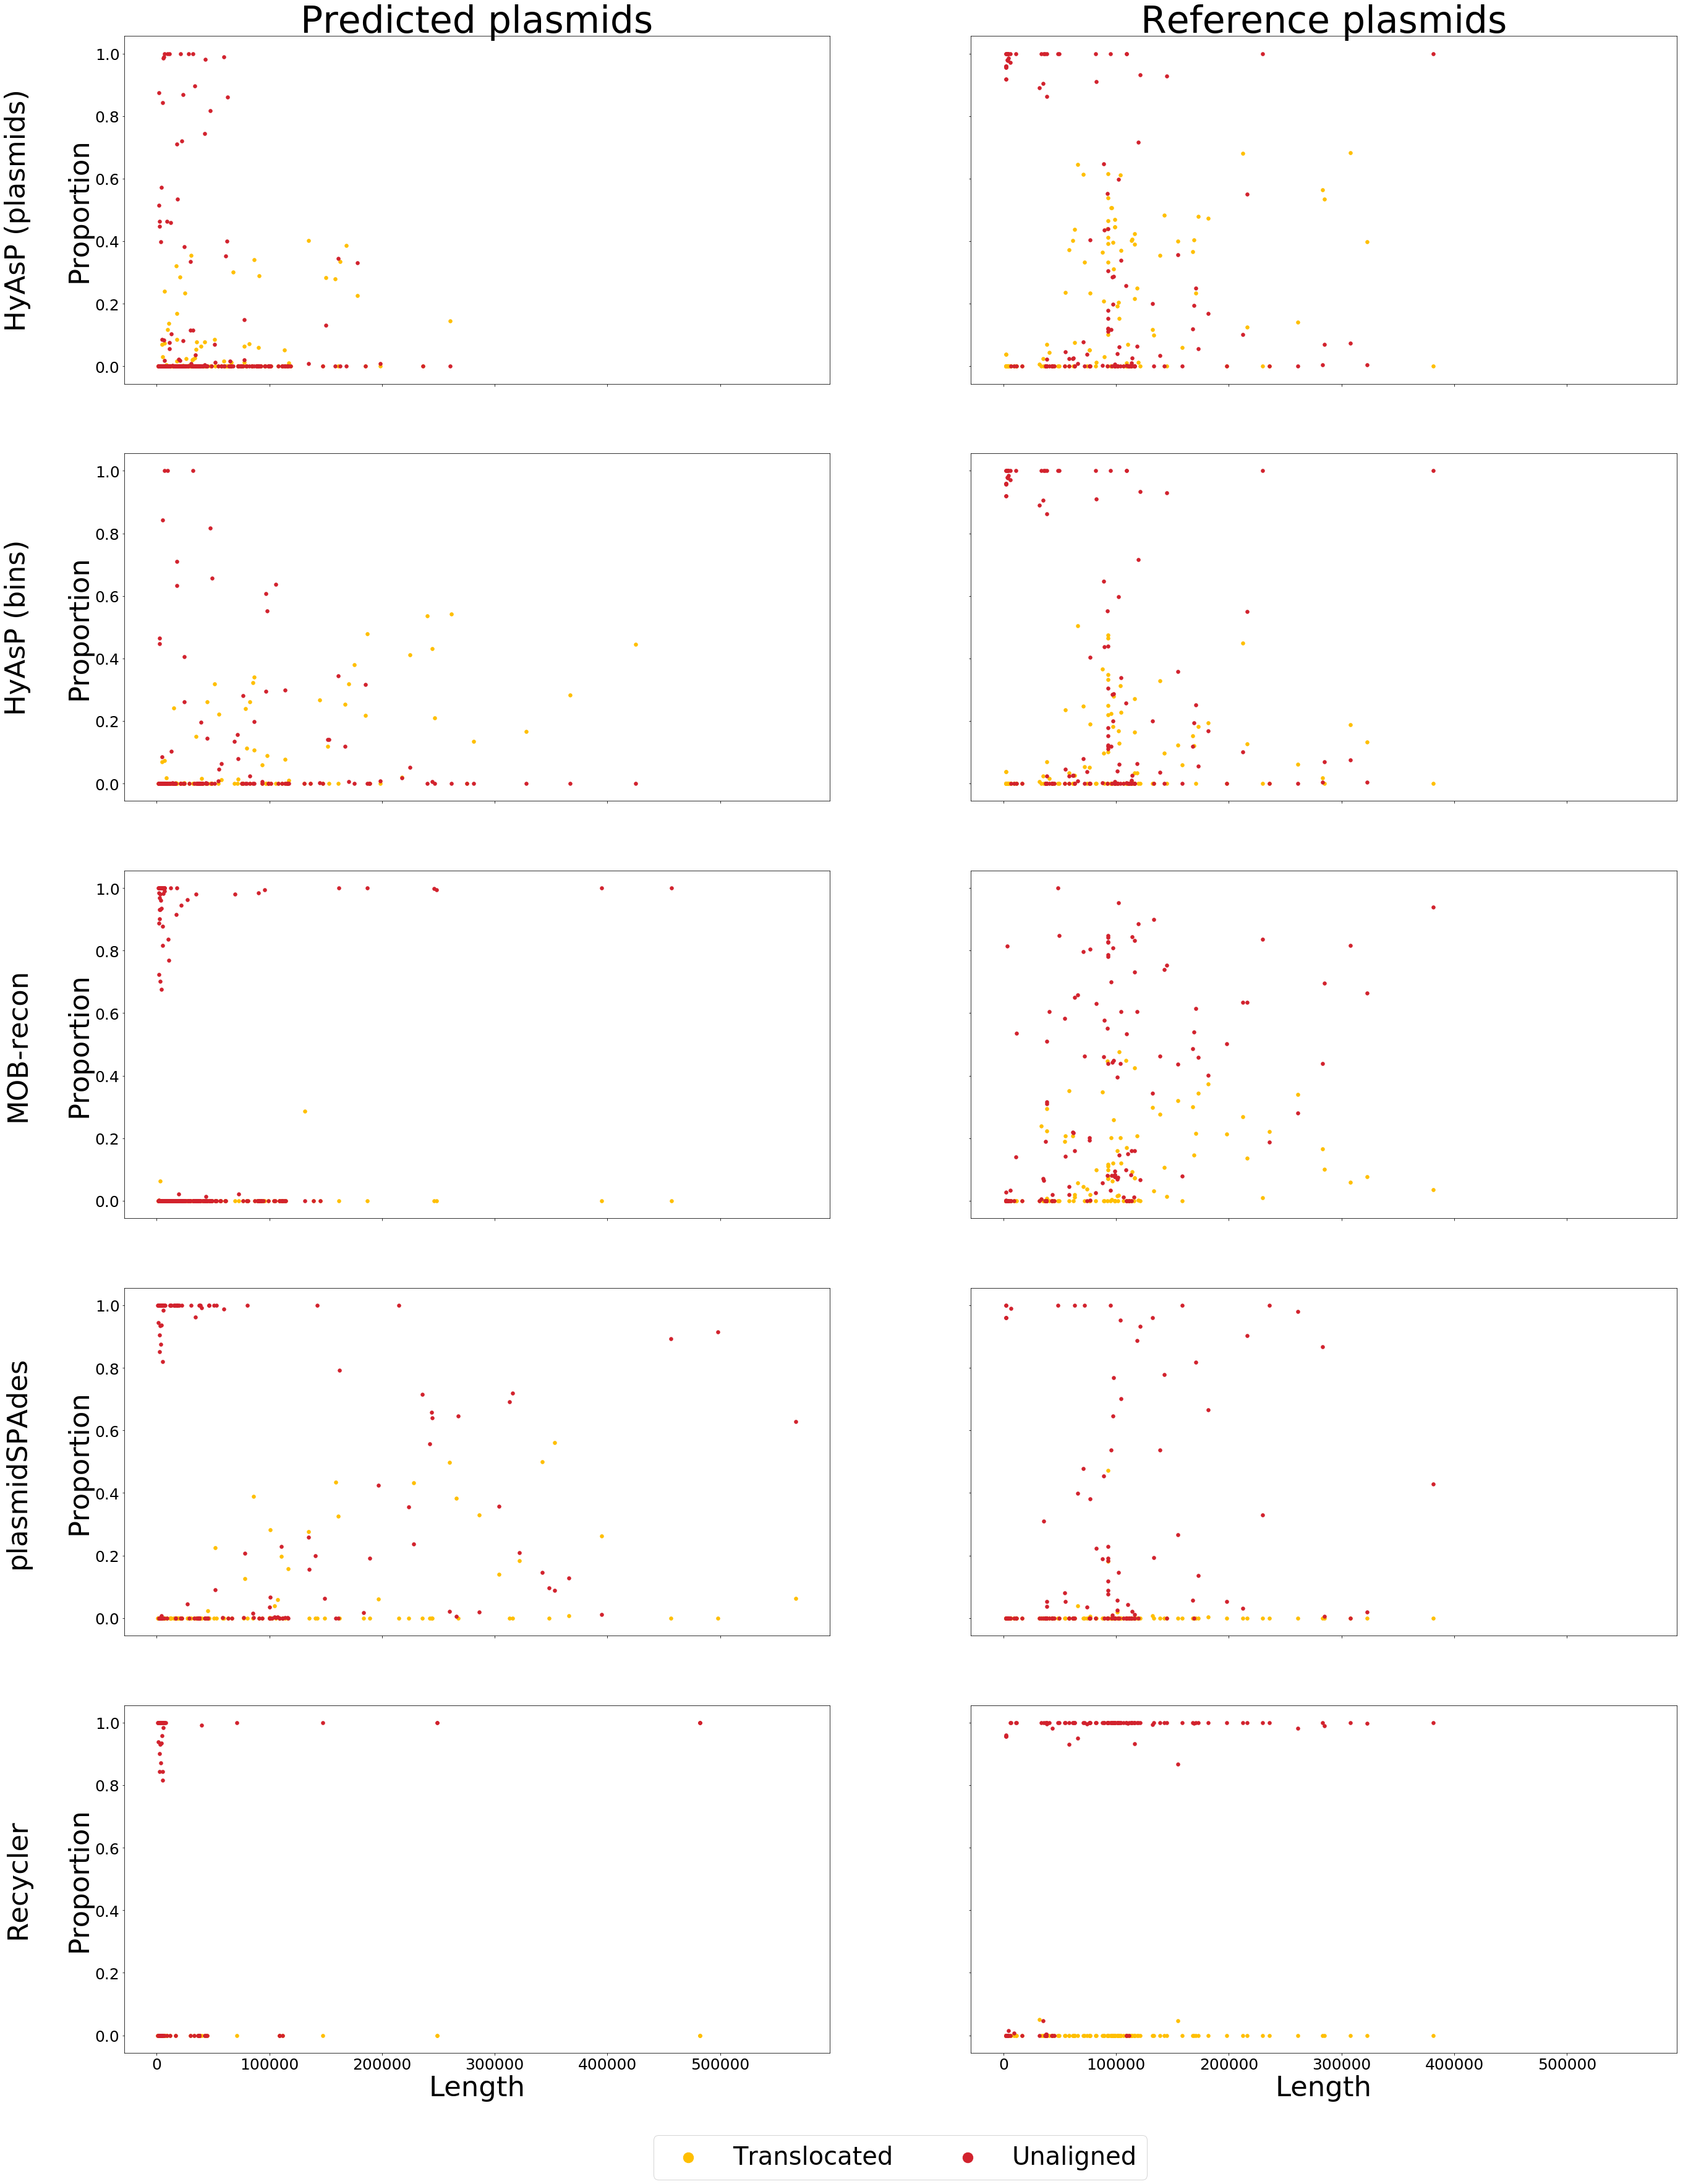

In [33]:
plot_length_vs_props_tools(all_results_mob_pred, all_results_mob_ref, 'length_vs_props_tools_mob')

### Scores

'matched' corresponds to best-scores, 'matched' plus 'translocated' corresponds to union-scores.

In [34]:
contents = []
for tool in totals_all_mob_pred['tool'].unique():
    pred_row = totals_all_mob_pred.loc[totals_all_mob_pred['tool'] == tool]
    pred_matched = pred_row['matched'].item()
    pred_translocated = pred_row['translocated'].item()
    
    ref_row = totals_all_mob_ref.loc[totals_all_mob_ref['tool'] == tool]
    ref_matched = ref_row['matched'].item()
    ref_translocated = ref_row['translocated'].item()
    
    best_precision = pred_matched
    best_recall = ref_matched
    best_f1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    
    union_precision = pred_matched + pred_translocated
    union_recall = ref_matched + ref_translocated
    union_f1 = 2 * union_precision * union_recall / (union_precision + union_recall) if (union_precision + union_recall) > 0 else 0
    
    contents.append([tool, 'union', union_precision, union_recall, union_f1])
    contents.append([tool, 'best', best_precision, best_recall, best_f1])
    
total_scores_all_mob = pd.DataFrame(contents, columns = ['tool', 'evaluation', 'precision', 'recall', 'f1'])
total_scores_all_mob

,tool,evaluation,precision,recall,f1
0,HyAsP_bins,union,0.934516,0.775171,0.847418
1,HyAsP_bins,best,0.798238,0.695159,0.743141
2,HyAsP_plasmids,union,0.934516,0.775171,0.847418
3,HyAsP_plasmids,best,0.887890,0.556486,0.684168
4,MOB-recon,union,0.760242,0.583911,0.660511
5,MOB-recon,best,0.756172,0.474530,0.583125
6,Recycler,union,0.349300,0.103779,0.160017
7,Recycler,best,0.349300,0.103061,0.159162
8,plasmidSPAdes,union,0.659212,0.741985,0.698154
9,plasmidSPAdes,best,0.560784,0.736594,0.636777


HyAsP_bins with binning factor 2.5

## NCBI-database

In [35]:
run = 'ncbi_filtered'
test_ids = [1,5,15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,55,56,62,63,64,65,66,76,85,86,87,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]

*Compute from scratch* (or see below to load from CSV file).

In [ ]:
all_results_pred = []
all_results_ref = []

# HyAsP (plasmids)
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/greedy/plasmids/greedy/putative_plasmids.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_hyasp_plasmids(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results

# HyAsP (bins)
bf = 2.5
for sid in test_ids:
    out_dir = 'hyasp_binning_option/%s/sample_%i/bins_%f' % (run, sid, bf)
    bin_list_file = '%s/plasmid_bins_putative.csv' % out_dir

    p = subprocess.Popen('ls %s/bin_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    predictions_files = output.rstrip().decode().split('\n')
    if predictions_files == ['']:
        predictions_files = []

    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/greedy/greedy_putative_map.csv' % (run, sid)

    pred_results, ref_results = analyse_hyasp_bins(sid, bf, bin_list_file, predictions_files, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results
    
# MOB-recon
for sid in test_ids:
    out_dir = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i' % (run, sid)

    p = subprocess.Popen('ls %s/mob_recon/plasmid_*.fasta' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    predictions_files = output.rstrip().decode().split('\n')
    if predictions_files == ['']:
        predictions_files = []

    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)

    p = subprocess.Popen('ls %s/eval/mob_recon/mob_recon_*_map.csv' % out_dir, stdout = subprocess.PIPE, shell = True)
    output, _ = p.communicate()
    p.wait()
    map_files = output.rstrip().decode().split('\n')
    if map_files == ['']:
        map_files = []
        
    pred_results, ref_results = analyse_mob_recon(sid, predictions_files, references_file, map_files)
    all_results_pred += pred_results
    all_results_ref += ref_results

# plasmidSPAdes
for sid in test_ids:
    out_dir = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i' % (run, sid)

    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/plasmidspades/scaffolds.fasta' % (run, sid)
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmidspades/plasmidspades_map.csv' % (run, sid)
    
    pred_results, ref_results = analyse_plasmidspades(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results

# Recycler
for sid in test_ids:
    predictions_file = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/plasmids/%i_assembly_graph.cycs.fasta' % sid
    references_file = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_%s/sample_%i/eval/plasmids.fasta' % (run, sid)
    map_file = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/eval/%i_recycler_map.csv' % sid
    
    pred_results, ref_results = analyse_recycler(sid, predictions_file, references_file, map_file)
    all_results_pred += pred_results
    all_results_ref += ref_results

all_results_ncbi_pred = pd.DataFrame(all_results_pred, columns = ['sample_id', 'tool', 'prediction', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
all_results_ncbi_pred.to_csv('all_results_ncbi_pred.csv', index = False)

all_results_ncbi_ref = pd.DataFrame(all_results_ref, columns = ['sample_id', 'tool', 'reference', 'length', 'matched', 'translocated', 'unaligned', 'bf'])
all_results_ncbi_ref.to_csv('all_results_ncbi_ref.csv', index = False)

*Load results from CSV files*

In [36]:
all_results_ncbi_pred = pd.read_csv('all_results_ncbi_pred.csv')
all_results_ncbi_ref = pd.read_csv('all_results_ncbi_ref.csv')

*Proportion of predicted plasmids with translocations*

In [37]:
contents = []
for t, grp in all_results_ncbi_pred.groupby(['tool']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([t, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['tool', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,tool,prop_translocated,num_translocated,num_matched,num_plasmids
0,HyAsP_bins,0.287582,44,153,202
1,HyAsP_plasmids,0.147959,58,392,490
2,MOB-recon,0.011583,3,259,286
3,Recycler,0.000000,0,60,108
4,plasmidSPAdes,0.230088,26,113,166


*Proportion of reference plasmids with translocations*

In [38]:
contents = []
for t, grp in all_results_ncbi_ref.groupby(['tool']):
    matched = grp.loc[grp['matched'] > 0.0]
    translocated = matched.loc[matched['translocated'] > 0.0]
    contents.append([t, len(translocated) / len(matched), len(translocated), len(matched), len(grp)])
pd.DataFrame(contents, columns = ['tool', 'prop_translocated', 'num_translocated', 'num_matched', 'num_plasmids'])

,tool,prop_translocated,num_translocated,num_matched,num_plasmids
0,HyAsP_bins,0.411348,58,141,147
1,HyAsP_plasmids,0.539007,76,141,147
2,MOB-recon,0.445205,65,146,147
3,Recycler,0.031250,2,64,147
4,plasmidSPAdes,0.050360,7,139,147


### Translocations w.r.t. predictions (precision)

Proportion of (nucleotides of) predicted plasmids corresponding to best respective reference ('matched'), other references ('translocated') and none of the references ('unaligned').

In [39]:
contents = []
for tool, grp in all_results_ncbi_pred.groupby(['tool']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([tool, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_all_ncbi_pred = pd.DataFrame(contents, columns = ['tool', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_all_ncbi_pred

,tool,total_length,matched,translocated,unaligned
0,HyAsP_bins,13145252,0.712097,0.159350,0.128553
1,HyAsP_plasmids,13145252,0.825117,0.046330,0.128553
2,MOB-recon,9307296,0.756172,0.004071,0.239758
3,Recycler,3654289,0.349300,0.000000,0.650700
4,plasmidSPAdes,13647445,0.560784,0.098428,0.340788


HyAsP_bins with binning factor 2.5

### Translocations w.r.t. references (recall)

Proportion of (nucleotides of) reference plasmids corresponding to respective best predicted plasmid ('matched'), other predicted plasmids ('translocated') and none of the predicted plasmids ('unaligned').

In [40]:
contents = []
for tool, grp in all_results_ncbi_ref.groupby(['tool']):
    total_len = 0
    total_matched = 0
    total_translocated = 0
    total_unaligned = 0
    for i, row in grp.iterrows():
        total_len += row['length']
        total_matched += row['length'] * row['matched']
        total_translocated += row['length'] * row['translocated']
        total_unaligned += row['length'] * row['unaligned']
    contents.append([tool, total_len, total_matched / total_len, total_translocated / total_len, total_unaligned / total_len])

totals_all_ncbi_ref = pd.DataFrame(contents, columns = ['tool', 'total_length', 'matched', 'translocated', 'unaligned'])
totals_all_ncbi_ref

,tool,total_length,matched,translocated,unaligned
0,HyAsP_bins,12435483,0.816356,0.082468,0.101176
1,HyAsP_plasmids,12435483,0.621696,0.277128,0.101176
2,MOB-recon,12435483,0.476373,0.107537,0.416089
3,Recycler,12435483,0.103061,0.000718,0.896221
4,plasmidSPAdes,12435483,0.736594,0.005391,0.258015


HyAsP_bins with binning factor 2.5

*Visualisation of translocations w.r.t. predictions and references for different tools*

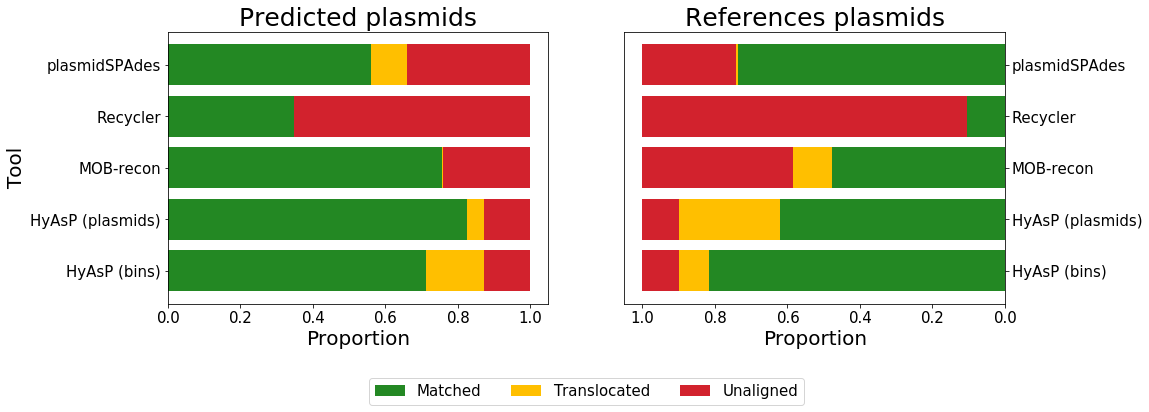

In [41]:
tick_labels = ['HyAsP (bins)', 'HyAsP (plasmids)', 'MOB-recon', 'Recycler', 'plasmidSPAdes']
plot_proportions(totals_all_ncbi_pred, totals_all_ncbi_ref, 'Tool', tick_labels, 'proportions_tools_ncbi')

*Visualisation of translocated and unaligned proportions of individual predicted and reference plasmids for different tools*

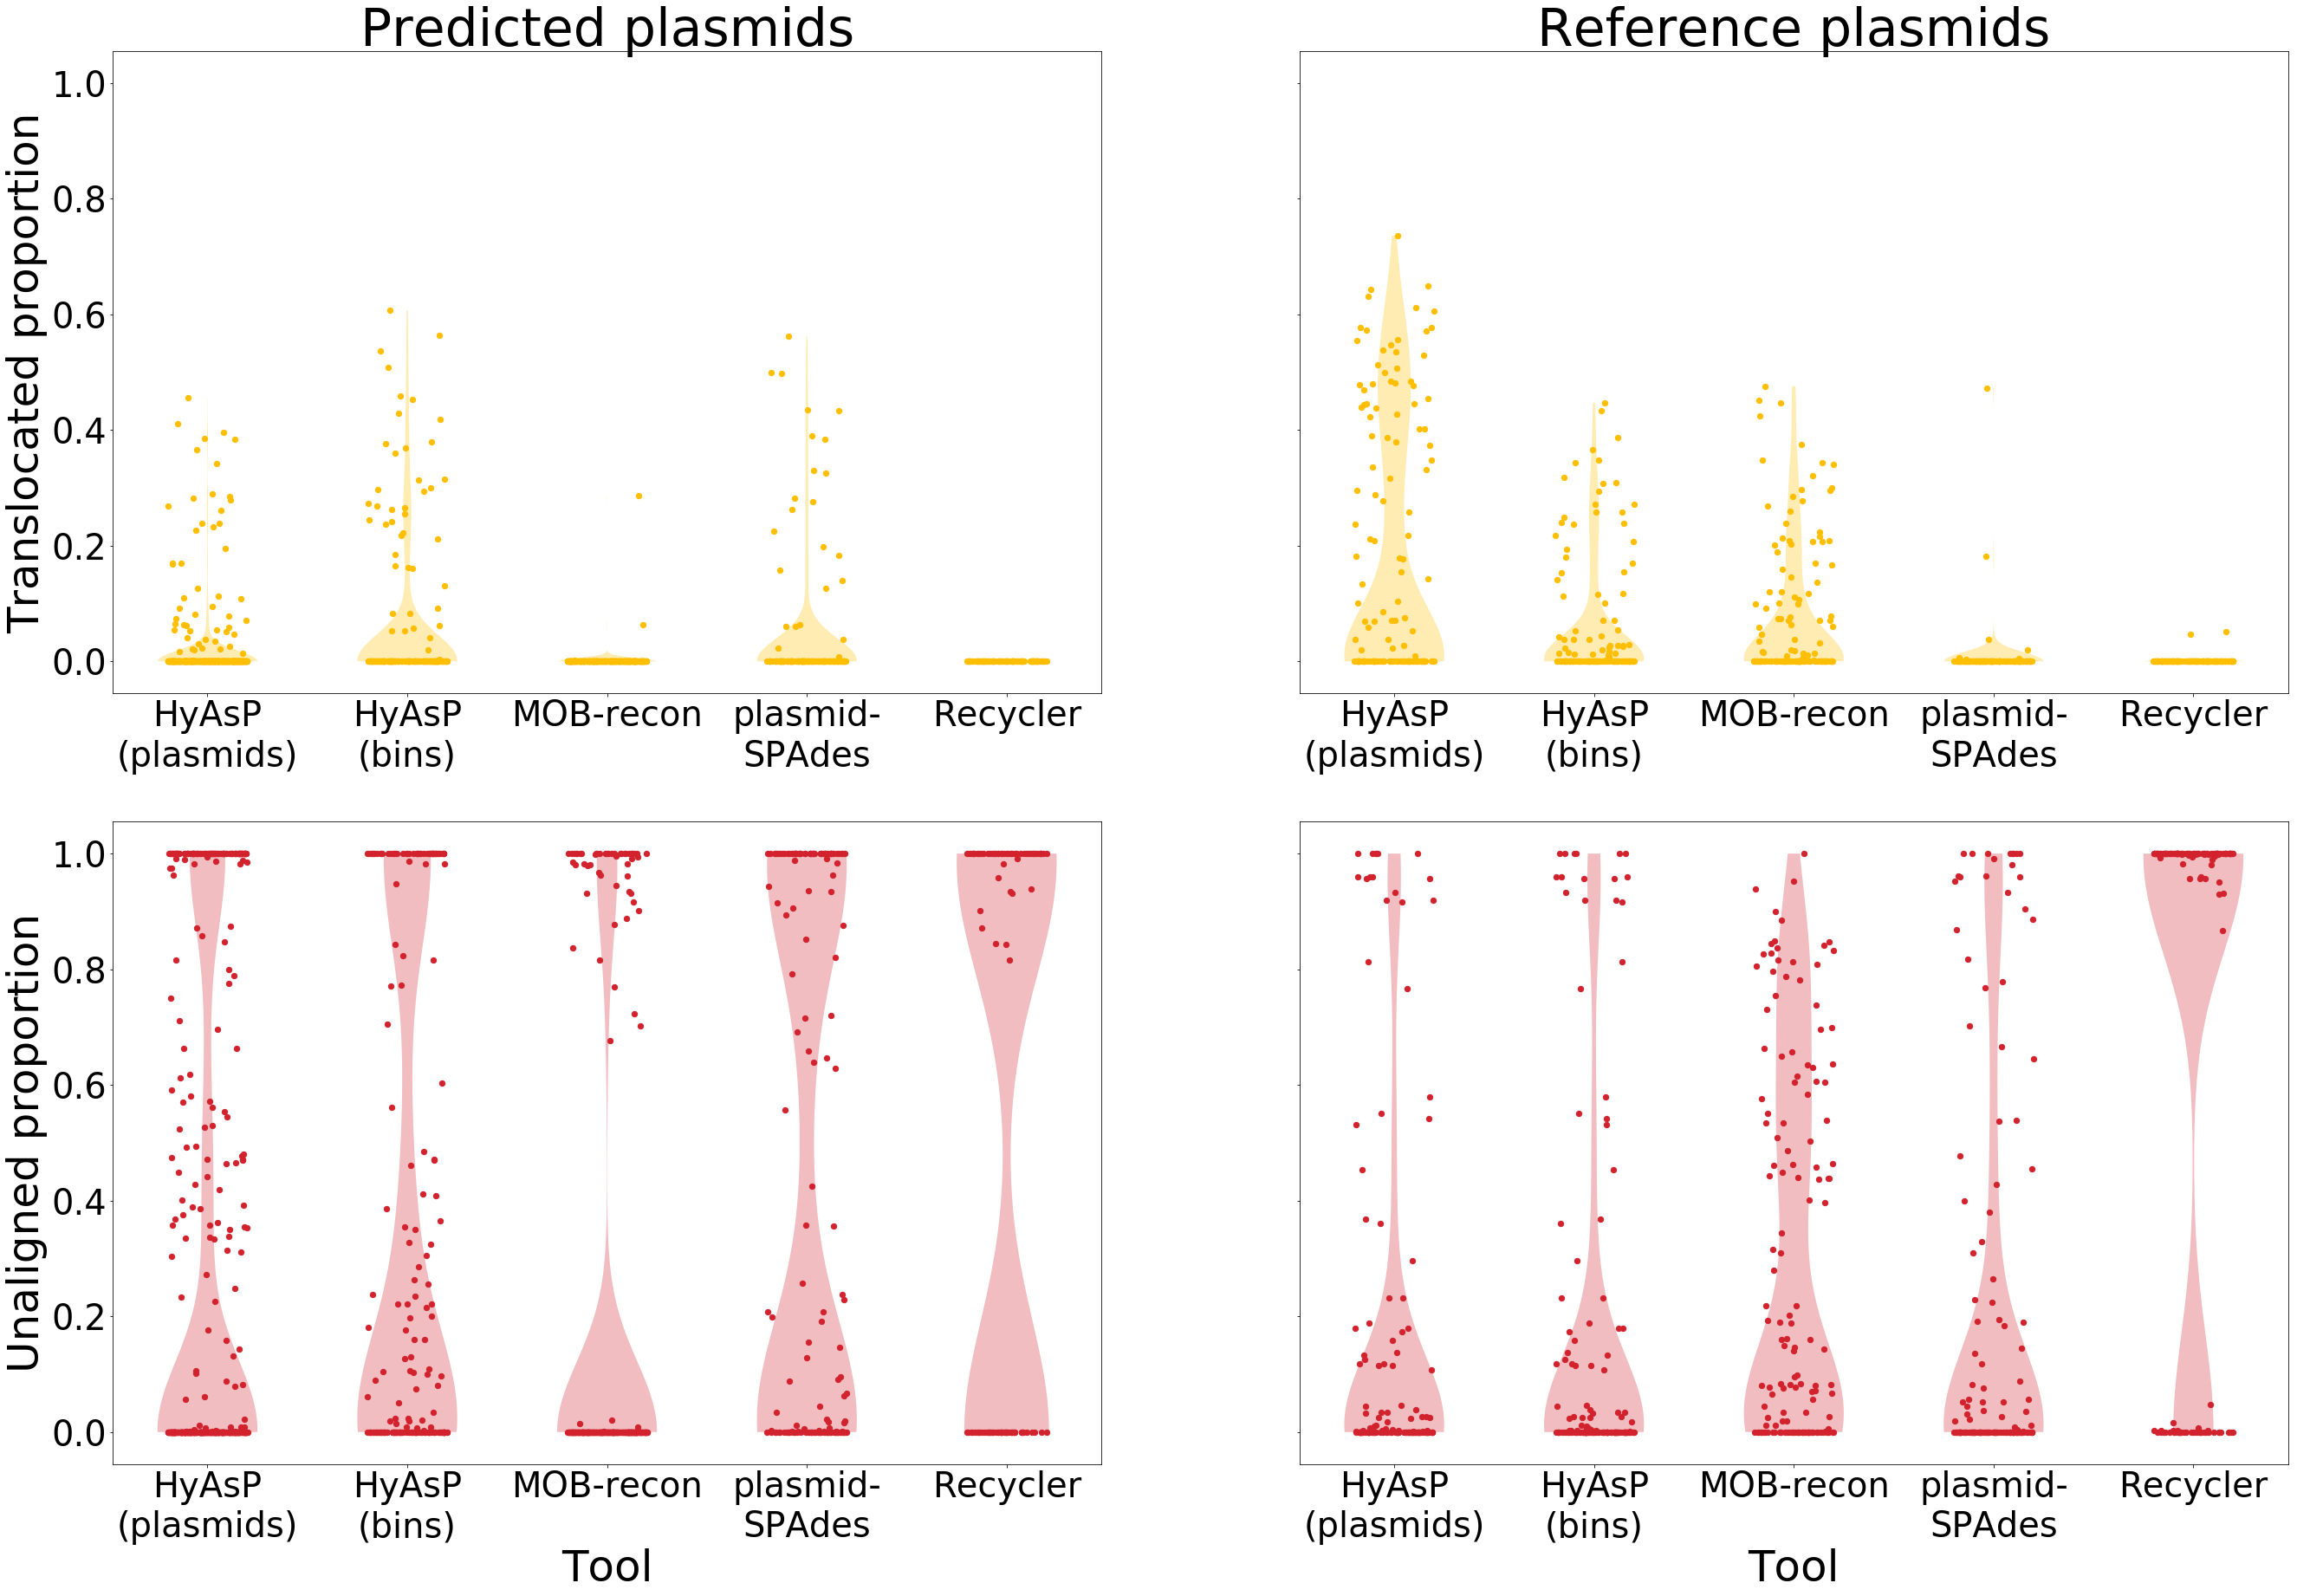

In [42]:
plot_distributions_tools(all_results_ncbi_pred, all_results_ncbi_ref, 'distributions_tools_ncbi')

*Length versus translocated / unaligned proportions of individual predicted and reference plasmids for different tools*

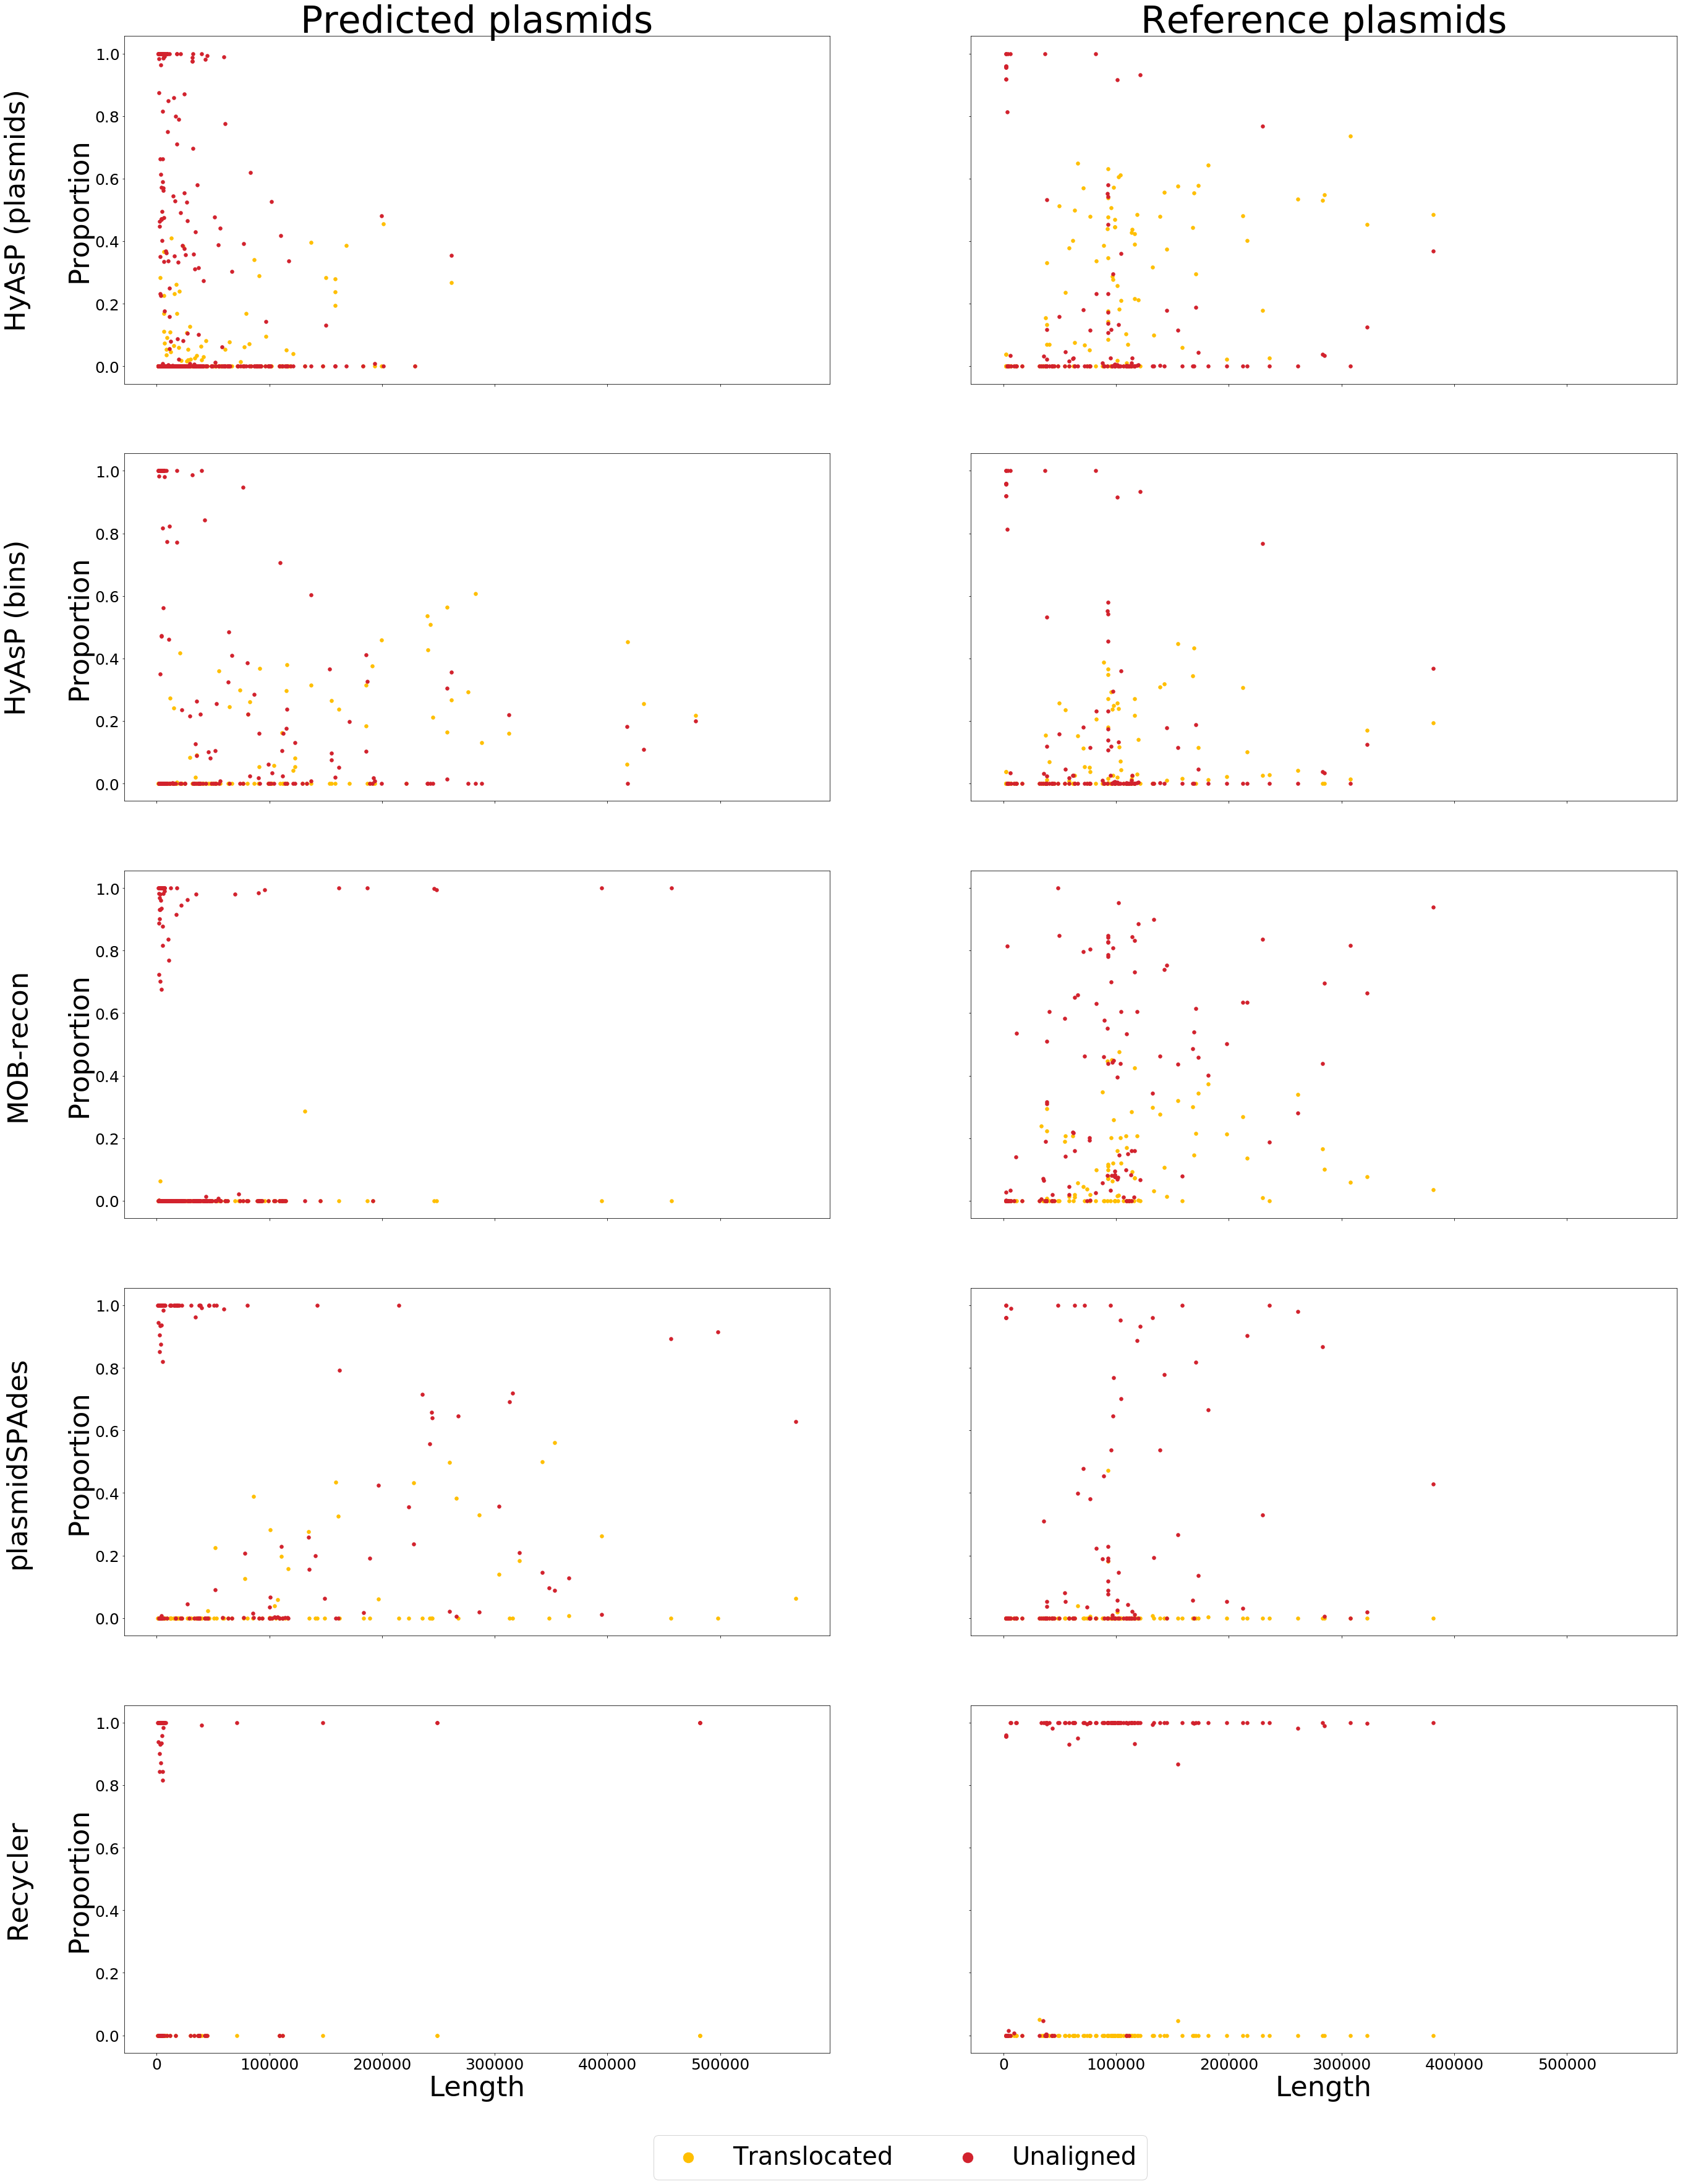

In [43]:
plot_length_vs_props_tools(all_results_ncbi_pred, all_results_ncbi_ref, 'length_vs_props_tools_ncbi')

### Scores

'matched' corresponds to best-scores, 'matched' plus 'translocated' corresponds to union-scores.

In [44]:
contents = []
for tool in totals_all_ncbi_pred['tool'].unique():
    pred_row = totals_all_ncbi_pred.loc[totals_all_ncbi_pred['tool'] == tool]
    pred_matched = pred_row['matched'].item()
    pred_translocated = pred_row['translocated'].item()
    
    ref_row = totals_all_ncbi_ref.loc[totals_all_ncbi_ref['tool'] == tool]
    ref_matched = ref_row['matched'].item()
    ref_translocated = ref_row['translocated'].item()
    
    best_precision = pred_matched
    best_recall = ref_matched
    best_f1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    
    union_precision = pred_matched + pred_translocated
    union_recall = ref_matched + ref_translocated
    union_f1 = 2 * union_precision * union_recall / (union_precision + union_recall) if (union_precision + union_recall) > 0 else 0
    
    contents.append([tool, 'union', union_precision, union_recall, union_f1])
    contents.append([tool, 'best', best_precision, best_recall, best_f1])
    
total_scores_all_ncbi = pd.DataFrame(contents, columns = ['tool', 'evaluation', 'precision', 'recall', 'f1'])
total_scores_all_ncbi

,tool,evaluation,precision,recall,f1
0,HyAsP_bins,union,0.871447,0.898824,0.884924
1,HyAsP_bins,best,0.712097,0.816356,0.760671
2,HyAsP_plasmids,union,0.871447,0.898824,0.884924
3,HyAsP_plasmids,best,0.825117,0.621696,0.709106
4,MOB-recon,union,0.760242,0.583911,0.660511
5,MOB-recon,best,0.756172,0.476373,0.584514
6,Recycler,union,0.349300,0.103779,0.160017
7,Recycler,best,0.349300,0.103061,0.159162
8,plasmidSPAdes,union,0.659212,0.741985,0.698154
9,plasmidSPAdes,best,0.560784,0.736594,0.636777


HyAsP_bins with binning factor 2.5